In [1]:
import os
import json
import requests
import time 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from functions import load_api_key, plotting

pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [2]:
hdb_df = pd.read_csv('inputs/HDBPropertyInformation.csv')
rental_data_df = pd.read_csv('inputs/rental_with_coordinates.csv')
time_distance_df = pd.read_csv('inputs/travelling_distance.csv')

# Merging HDBPropertyInformation and rental_with_coordinates

In [3]:
hdb_df['address'] = hdb_df['blk_no'] + ' ' + hdb_df['street'] 

In [4]:
rental_data_df = pd.merge(rental_data_df, 
                          hdb_df[['max_floor_lvl', 'year_completed', 'residential', 'commercial', 
                                  'market_hawker', 'miscellaneous', 'multistorey_carpark', 'precinct_pavilion', 'address']], 
                          how = 'left', 
                          on = 'address')

In [5]:
rental_data_df.shape

(142826, 22)

In [6]:
rental_data_df.isna().sum()

rent_approval_date      0
town                    0
block                   0
street_name             0
flat_type               0
monthly_rent            0
address                 0
date                    0
year                    0
month                   0
year_month              0
postal_code             0
latitude                0
longitude               0
max_floor_lvl          52
year_completed         52
residential            52
commercial             52
market_hawker          52
miscellaneous          52
multistorey_carpark    52
precinct_pavilion      52
dtype: int64

In [7]:
rental_data_df[rental_data_df['max_floor_lvl'].isna()]

,rent_approval_date,town,block,street_name,flat_type,monthly_rent,address,date,year,month,year_month,postal_code,latitude,longitude,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion
2082,2021-01,QUEENSTOWN,26,TANGLIN HALT RD,3-ROOM,1350,26 TANGLIN HALT RD,2021-01-01,2021,1,2021_1,141026,1.298106,103.799781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2083,2021-01,QUEENSTOWN,26,TANGLIN HALT RD,2-ROOM,1300,26 TANGLIN HALT RD,2021-01-01,2021,1,2021_1,141026,1.298106,103.799781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2084,2021-01,QUEENSTOWN,26,TANGLIN HALT RD,3-ROOM,1800,26 TANGLIN HALT RD,2021-01-01,2021,1,2021_1,141026,1.298106,103.799781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2086,2021-01,QUEENSTOWN,27,TANGLIN HALT RD,3-ROOM,1500,27 TANGLIN HALT RD,2021-01-01,2021,1,2021_1,142027,1.298325,103.799839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2088,2021-01,QUEENSTOWN,28,TANGLIN HALT RD,3-ROOM,1700,28 TANGLIN HALT RD,2021-01-01,2021,1,2021_1,140028,1.298543,103.799898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2090,2021-01,QUEENSTOWN,30,TANGLIN HALT RD,3-ROOM,1700,30 TANGLIN HALT RD,2021-01-01,2021,1,2021_1,140030,1.299106,103.799562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2091,2021-01,QUEENSTOWN,31,TANGLIN HALT RD,3-ROOM,1800,31 TANGLIN HALT RD,2021-01-01,2021,1,2021_1,141031,1.299362,103.799471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2092,2021-01,QUEENSTOWN,31,TANGLIN HALT RD,3-ROOM,1600,31 TANGLIN HALT RD,2021-01-01,2021,1,2021_1,141031,1.299362,103.799471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2093,2021-01,QUEENSTOWN,31,TANGLIN HALT RD,2-ROOM,1000,31 TANGLIN HALT RD,2021-01-01,2021,1,2021_1,141031,1.299362,103.799471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2098,2021-01,QUEENSTOWN,40,TANGLIN HALT RD,3-ROOM,1700,40 TANGLIN HALT RD,2021-01-01,2021,1,2021_1,143040,1.297986,103.798581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
rental_data_df['age'] = int(datetime.now().year) - rental_data_df['year_completed']
rental_data_df['age'].describe()

count    142774.000000
mean         34.599885
std          12.717714
min           0.000000
25%          25.000000
50%          37.000000
75%          45.000000
max          75.000000
Name: age, dtype: float64

In [9]:
rental_data_df['age'] = pd.to_numeric(rental_data_df['age'], errors='coerce')
bins = range(0, int(rental_data_df['age'].max()) + 5, 5)  
rental_data_df['age_group'] = pd.cut(rental_data_df['age'], bins=bins, right=False)

## EDA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


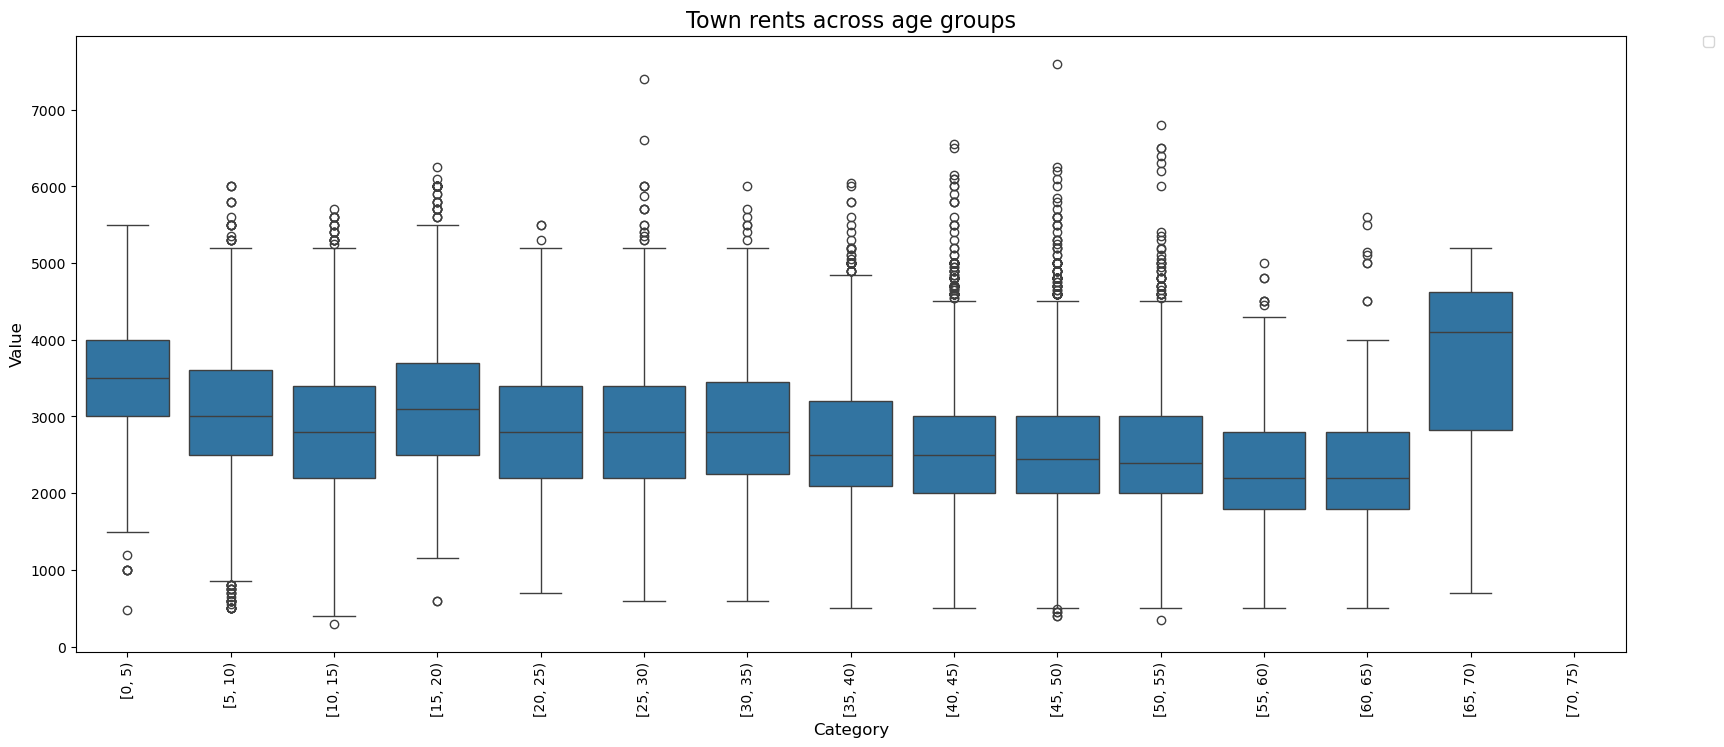

In [10]:
plotting('Town rents across age groups', 'boxplot', rental_data_df, 'age_group', 'monthly_rent')

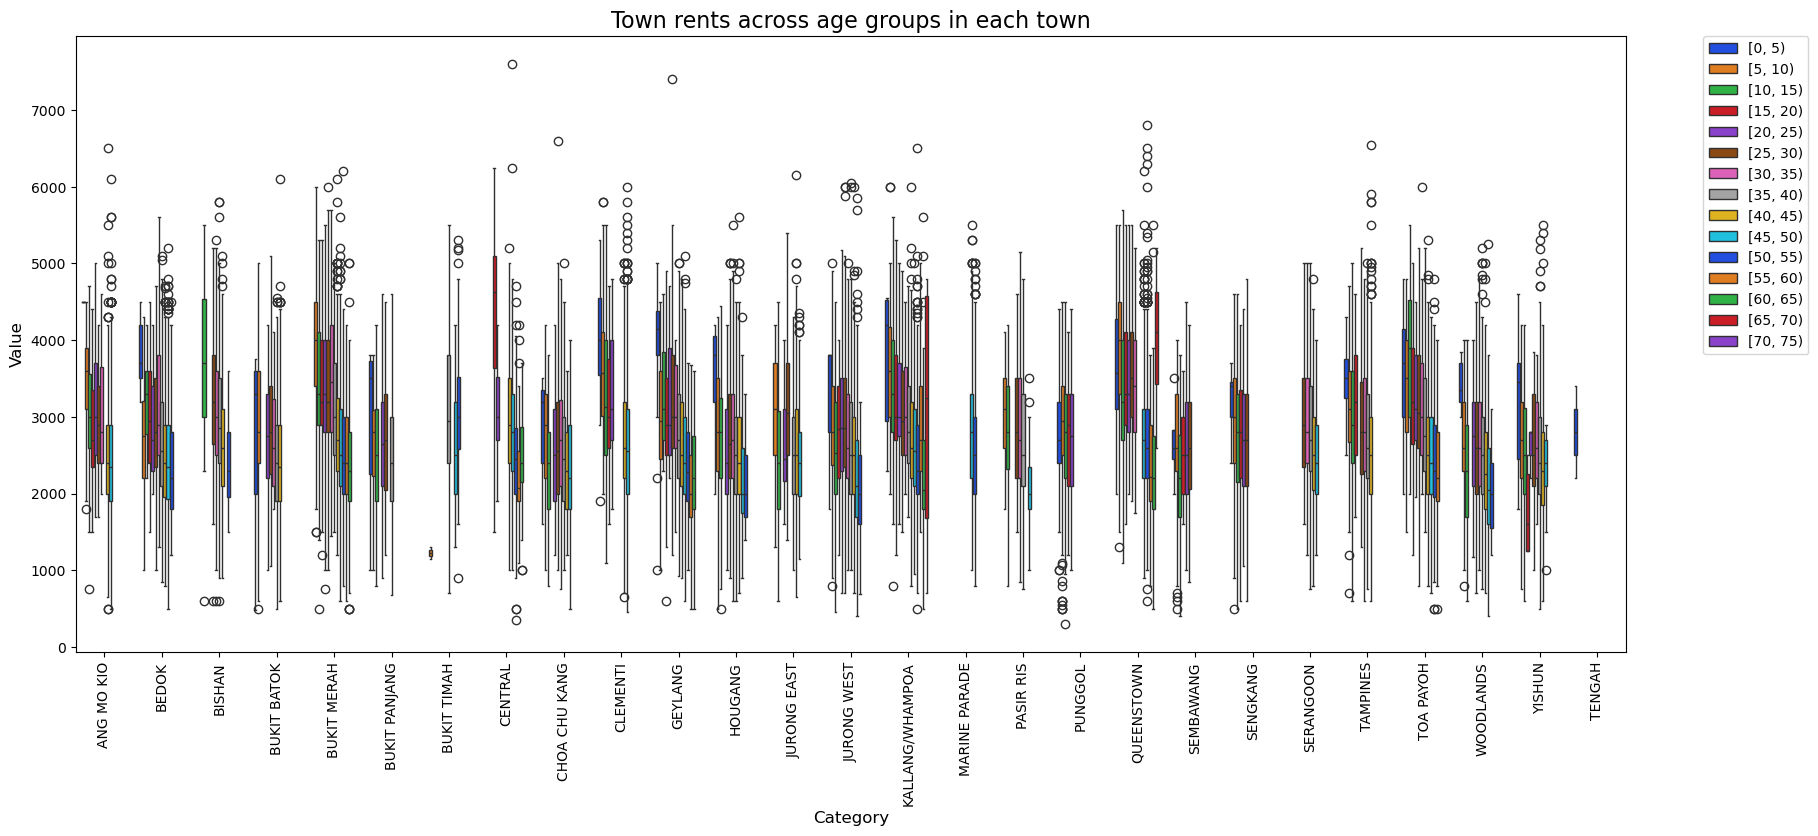

In [26]:
plotting('Town rents across age groups in each town', 'boxplot', rental_data_df, 'town', 'monthly_rent', 'age_group')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


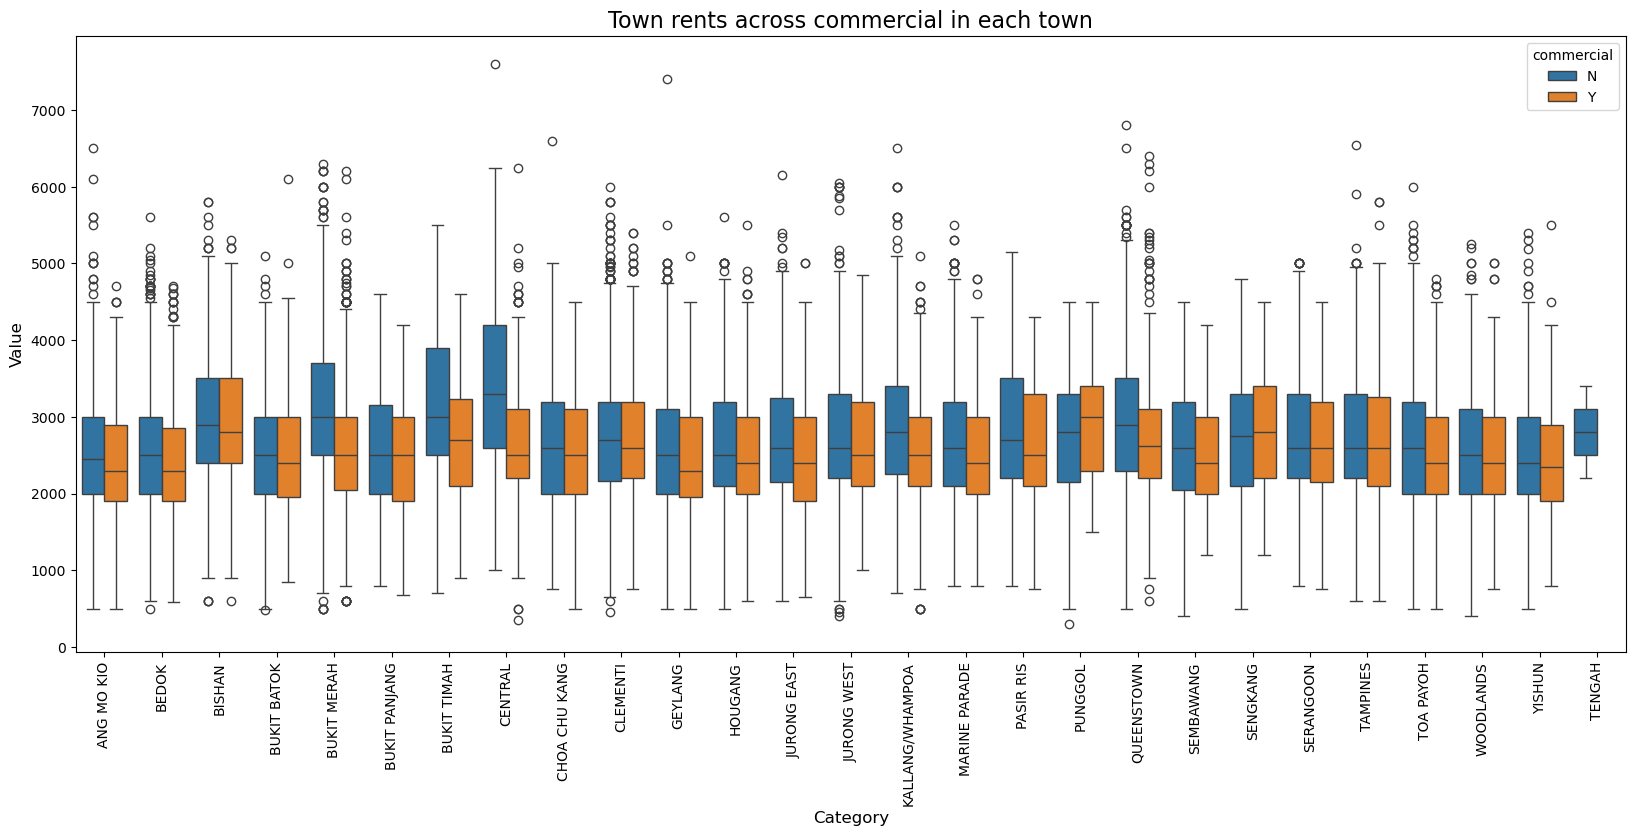

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


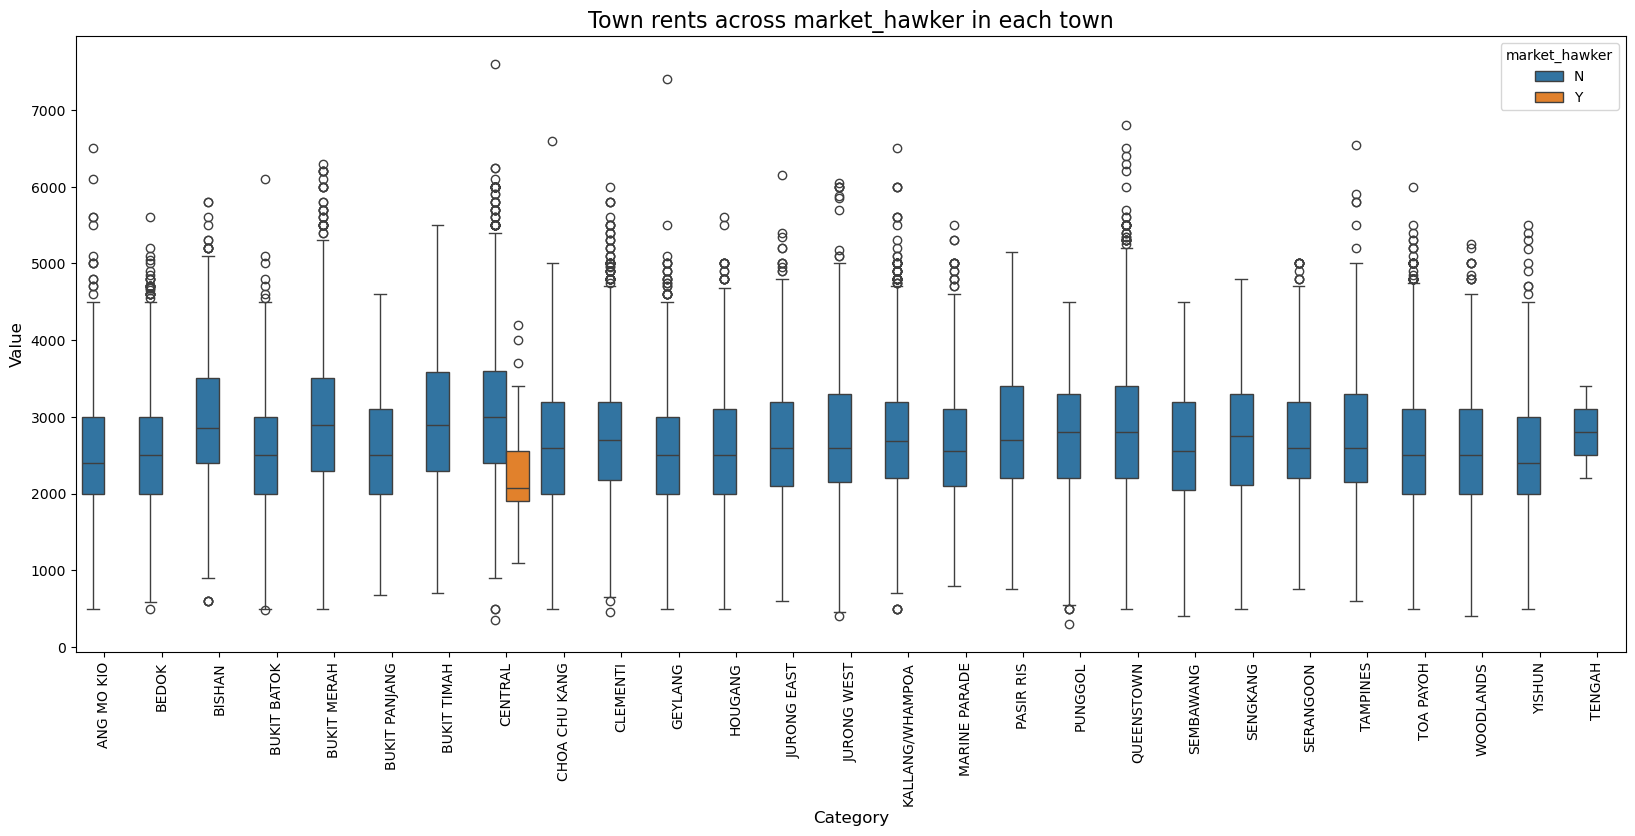

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


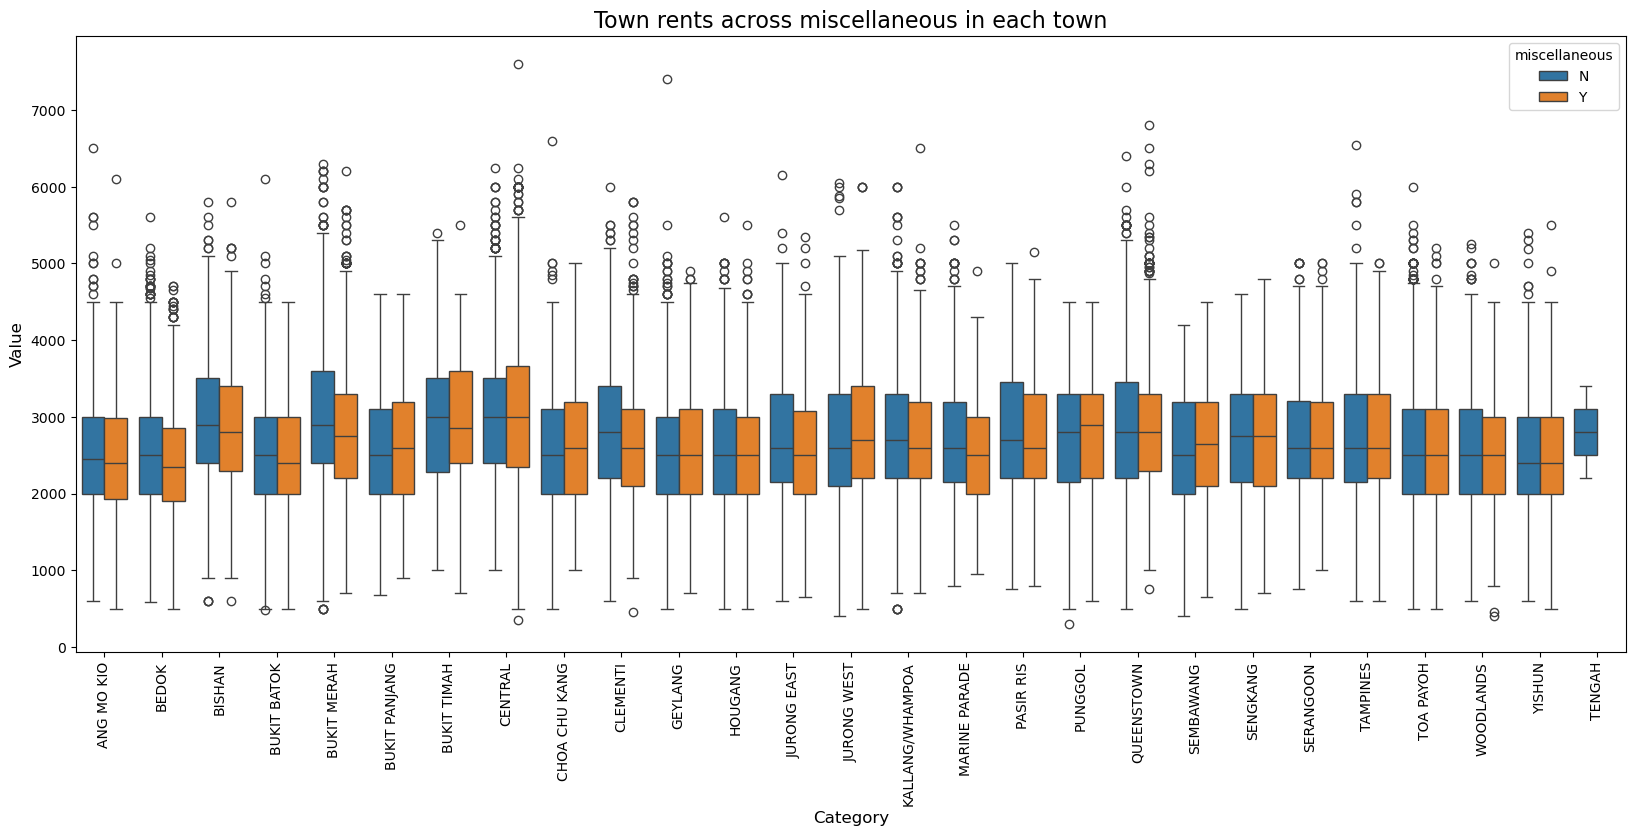

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


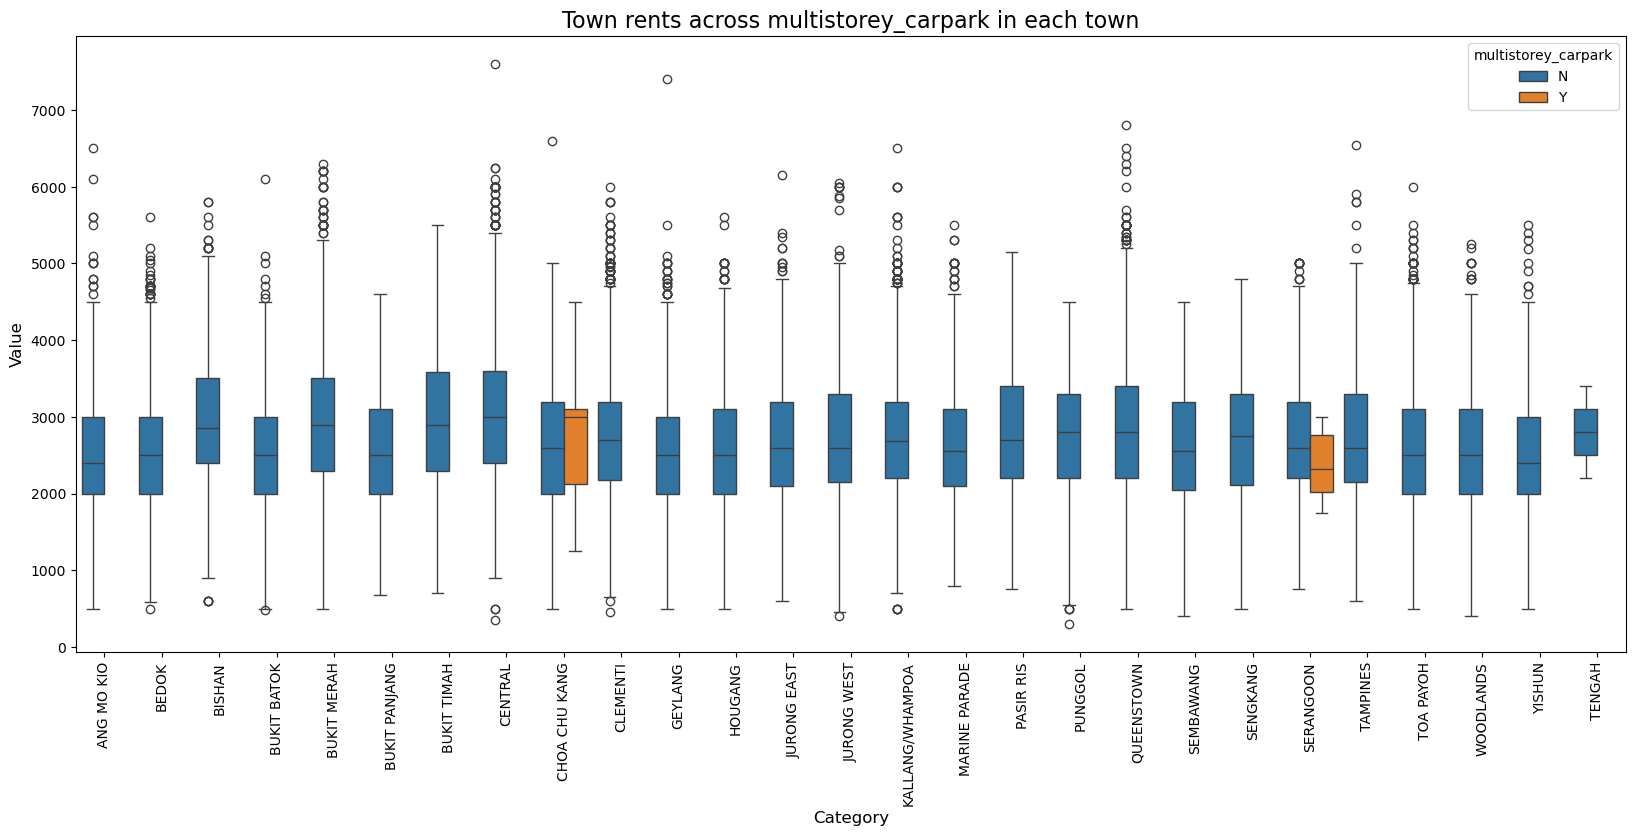

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


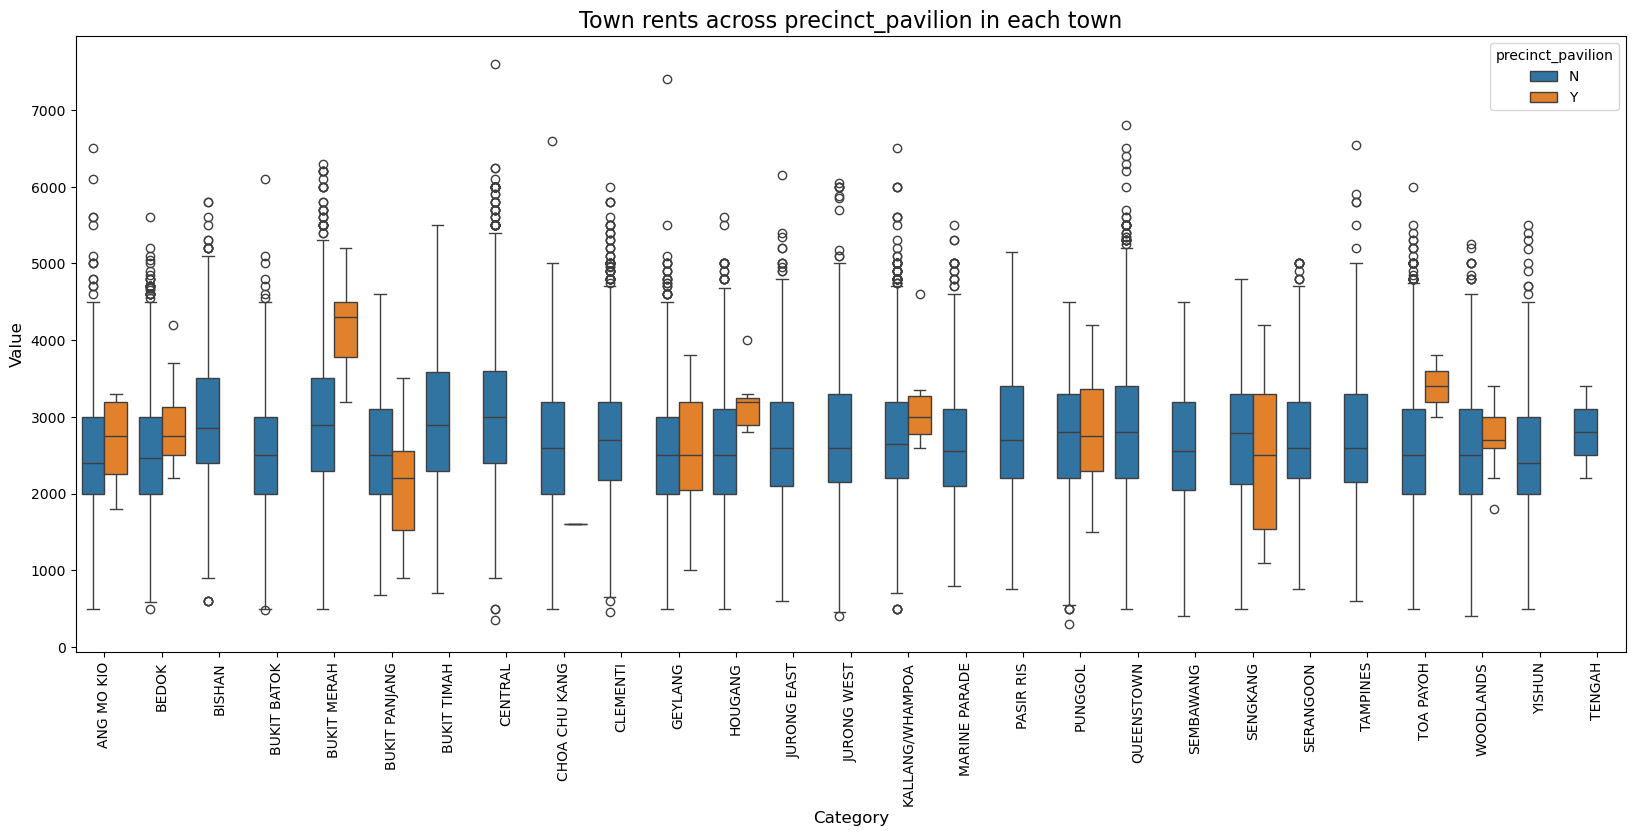

In [12]:
amenties = ['commercial', 'market_hawker', 'miscellaneous', 'multistorey_carpark', 'precinct_pavilion']
for amenity in amenties:
    plotting(f'Town rents across {amenity} in each town', 'boxplot', rental_data_df, 'town', 'monthly_rent', amenity)

# Merging again with travelling_distance

In [14]:
time_distance_df.head()

,postal_code,latitude,longitude,station_station_code,station_station_name,station_postal_code,station_latitude,station_longitude,walking_time_s,walking_distance_m,hervsine_distance
0,190001,1.303671,103.864479,CC5,NICOLL HIGHWAY MRT STATION (CC5),38970,1.299767,103.863637,438.0,609.0,0.444129
1,190001,1.303671,103.864479,EW11,LAVENDER MRT STATION (EW11),208699,1.307378,103.862768,512.0,711.0,0.453915
2,190001,1.303671,103.864479,DT14,BUGIS MRT STATION (DT14),188476,1.299314,103.857126,787.0,1093.0,0.950214
3,460001,1.320852,103.933721,EW5,BEDOK MRT STATION (EW5),467347,1.323980,103.929984,690.0,959.0,0.541764
4,460001,1.320852,103.933721,TE28,SIGLAP MRT STATION (TE28),449969,1.310009,103.930026,1191.0,1654.0,1.273786


In [15]:
time_distance_df['postal_code'].nunique()

9542

In [16]:
fastest_time_df = time_distance_df.loc[time_distance_df.groupby(['postal_code', 'latitude', 'longitude'])['walking_time_s'].idxmin()]

In [17]:
rental_data_df['postal_code'] = rental_data_df['postal_code'].astype(int)

In [18]:
main_rental_data_df = rental_data_df.merge(fastest_time_df, on = ['postal_code', 'latitude', 'longitude'])

In [19]:
main_rental_data_df.columns

Index(['rent_approval_date', 'town', 'block', 'street_name', 'flat_type',
       'monthly_rent', 'address', 'date', 'year', 'month', 'year_month',
       'postal_code', 'latitude', 'longitude', 'max_floor_lvl',
       'year_completed', 'residential', 'commercial', 'market_hawker',
       'miscellaneous', 'multistorey_carpark', 'precinct_pavilion', 'age',
       'age_group', 'station_station_code', 'station_station_name',
       'station_postal_code', 'station_latitude', 'station_longitude',
       'walking_time_s', 'walking_distance_m', 'hervsine_distance'],
      dtype='object')

In [20]:
main_rental_data_df['walking_time_s'] = pd.to_numeric(main_rental_data_df['walking_time_s'], errors='coerce')
interval = 300
bins = range(0, int(main_rental_data_df['walking_time_s'].max()) + interval, interval)  
main_rental_data_df['walking_time_interval'] = pd.cut(main_rental_data_df['walking_time_s'], bins=bins, right=False)

## EDA

In [21]:
main_rental_data_df

,rent_approval_date,town,block,street_name,flat_type,monthly_rent,address,date,year,month,year_month,postal_code,latitude,longitude,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,age,age_group,station_station_code,station_station_name,station_postal_code,station_latitude,station_longitude,walking_time_s,walking_distance_m,hervsine_distance,walking_time_interval
0,2021-01,ANG MO KIO,105,ANG MO KIO AVE 4,4-ROOM,2000,105 ANG MO KIO AVE 4,2021-01-01,2021,1,2021_1,560105,1.372313,103.837601,10.0,1977.0,Y,N,N,N,N,N,47.0,"[45, 50)",TE6,MAYFLOWER MRT STATION (TE6),569900,1.371463,103.836568,209.0,291.0,0.148763,"[0, 300)"
1,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3-ROOM,1750,107 ANG MO KIO AVE 4,2021-01-01,2021,1,2021_1,560107,1.371384,103.837381,11.0,1977.0,Y,Y,N,N,N,N,47.0,"[45, 50)",TE6,MAYFLOWER MRT STATION (TE6),569900,1.371463,103.836568,110.0,153.0,0.090875,"[0, 300)"
2,2021-01,ANG MO KIO,108,ANG MO KIO AVE 4,3-ROOM,1750,108 ANG MO KIO AVE 4,2021-01-01,2021,1,2021_1,560108,1.370966,103.838202,12.0,1978.0,Y,Y,N,N,N,N,46.0,"[45, 50)",TE6,MAYFLOWER MRT STATION (TE6),569900,1.371463,103.836568,191.0,266.0,0.189875,"[0, 300)"
3,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2230,111 ANG MO KIO AVE 4,2021-01-01,2021,1,2021_1,560111,1.370851,103.837298,12.0,1977.0,Y,N,N,Y,N,N,47.0,"[45, 50)",TE6,MAYFLOWER MRT STATION (TE6),569900,1.371463,103.836568,120.0,167.0,0.105918,"[0, 300)"
4,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2450,111 ANG MO KIO AVE 4,2021-01-01,2021,1,2021_1,560111,1.370851,103.837298,12.0,1977.0,Y,N,N,Y,N,N,47.0,"[45, 50)",TE6,MAYFLOWER MRT STATION (TE6),569900,1.371463,103.836568,120.0,167.0,0.105918,"[0, 300)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142821,2024-11,CLEMENTI,708,CLEMENTI WEST ST 2,4-ROOM,3800,708 CLEMENTI WEST ST 2,2024-11-01,2024,11,2024_11,120708,1.305719,103.762168,12.0,1980.0,Y,N,N,Y,N,N,44.0,"[40, 45)",EW23,CLEMENTI MRT STATION (EW23),129580,1.315116,103.765191,1122.0,1557.0,1.097689,"[900, 1200)"
142822,2024-11,YISHUN,225,YISHUN ST 21,4-ROOM,3000,225 YISHUN ST 21,2024-11-01,2024,11,2024_11,760225,1.434831,103.835814,12.0,1984.0,Y,N,N,Y,N,N,40.0,"[40, 45)",NS13,YISHUN MRT STATION (NS13),769093,1.429443,103.835005,550.0,764.0,0.605857,"[300, 600)"
142823,2024-11,PUNGGOL,134,EDGEDALE PLAINS,5-ROOM,3200,134 EDGEDALE PLAINS,2024-11-01,2024,11,2024_11,820134,1.392335,103.910181,18.0,2001.0,Y,N,N,N,N,N,23.0,"[20, 25)",PE3,CORAL EDGE LRT STATION (PE3),828856,1.393909,103.912581,322.0,447.0,0.319070,"[300, 600)"
142824,2024-11,JURONG EAST,44,TEBAN GDNS RD,4-ROOM,3500,44 TEBAN GDNS RD,2024-11-01,2024,11,2024_11,600044,1.320754,103.741600,12.0,1985.0,Y,Y,N,Y,N,N,39.0,"[35, 40)",EW24,JURONG EAST MRT STATION (EW24 / NS1),609690,1.333153,103.742286,1660.0,2305.0,1.380803,"[1500, 1800)"


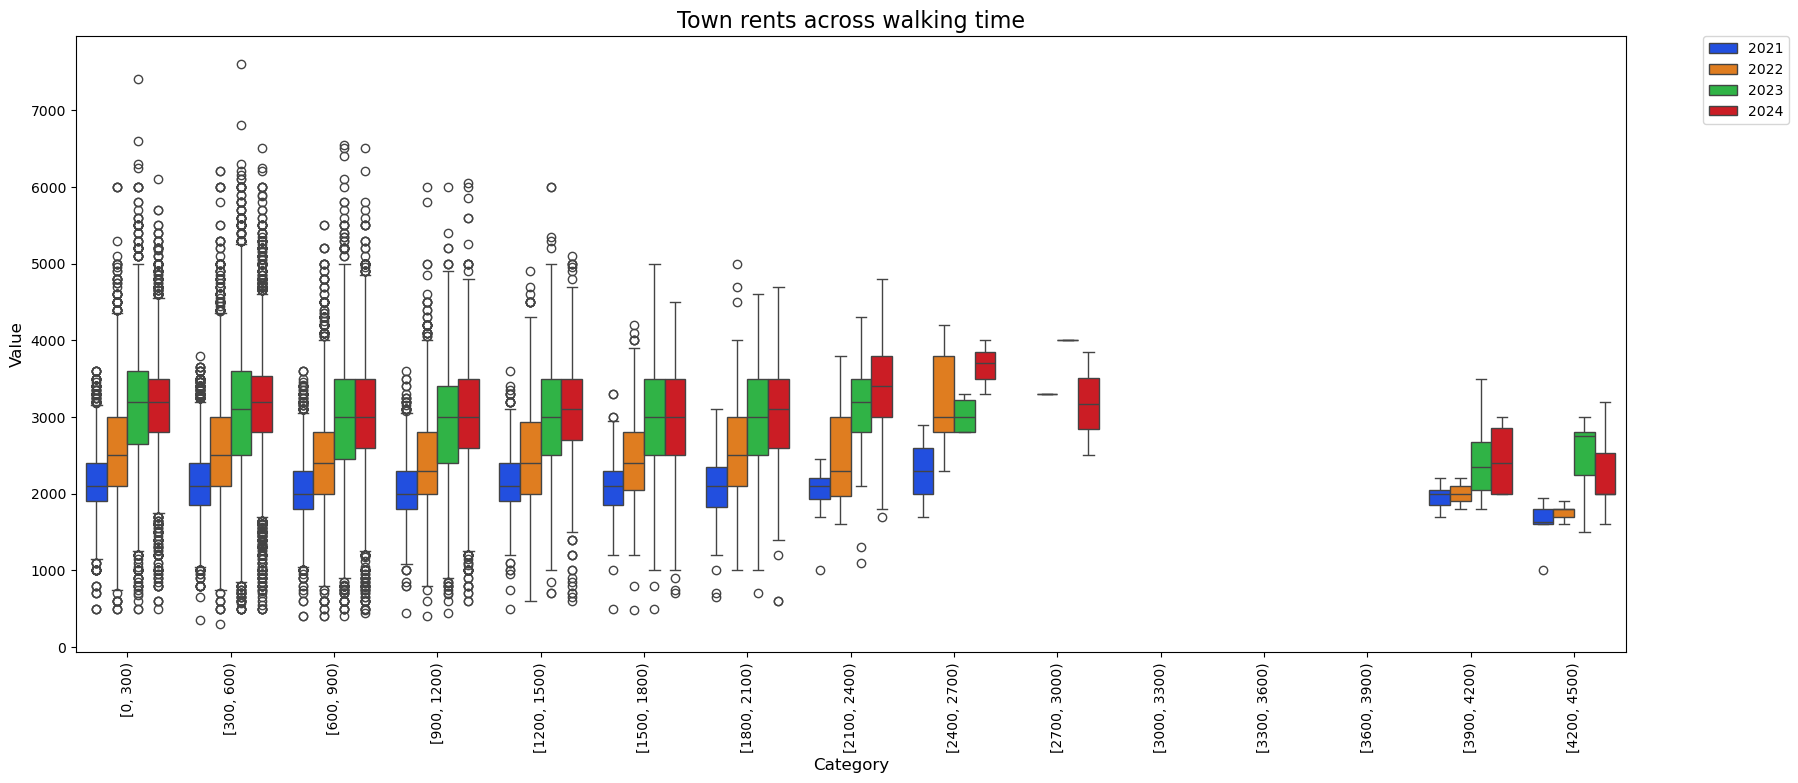

In [27]:
plotting('Town rents across walking time', 'boxplot', main_rental_data_df, 'walking_time_interval', 'monthly_rent', 'year')

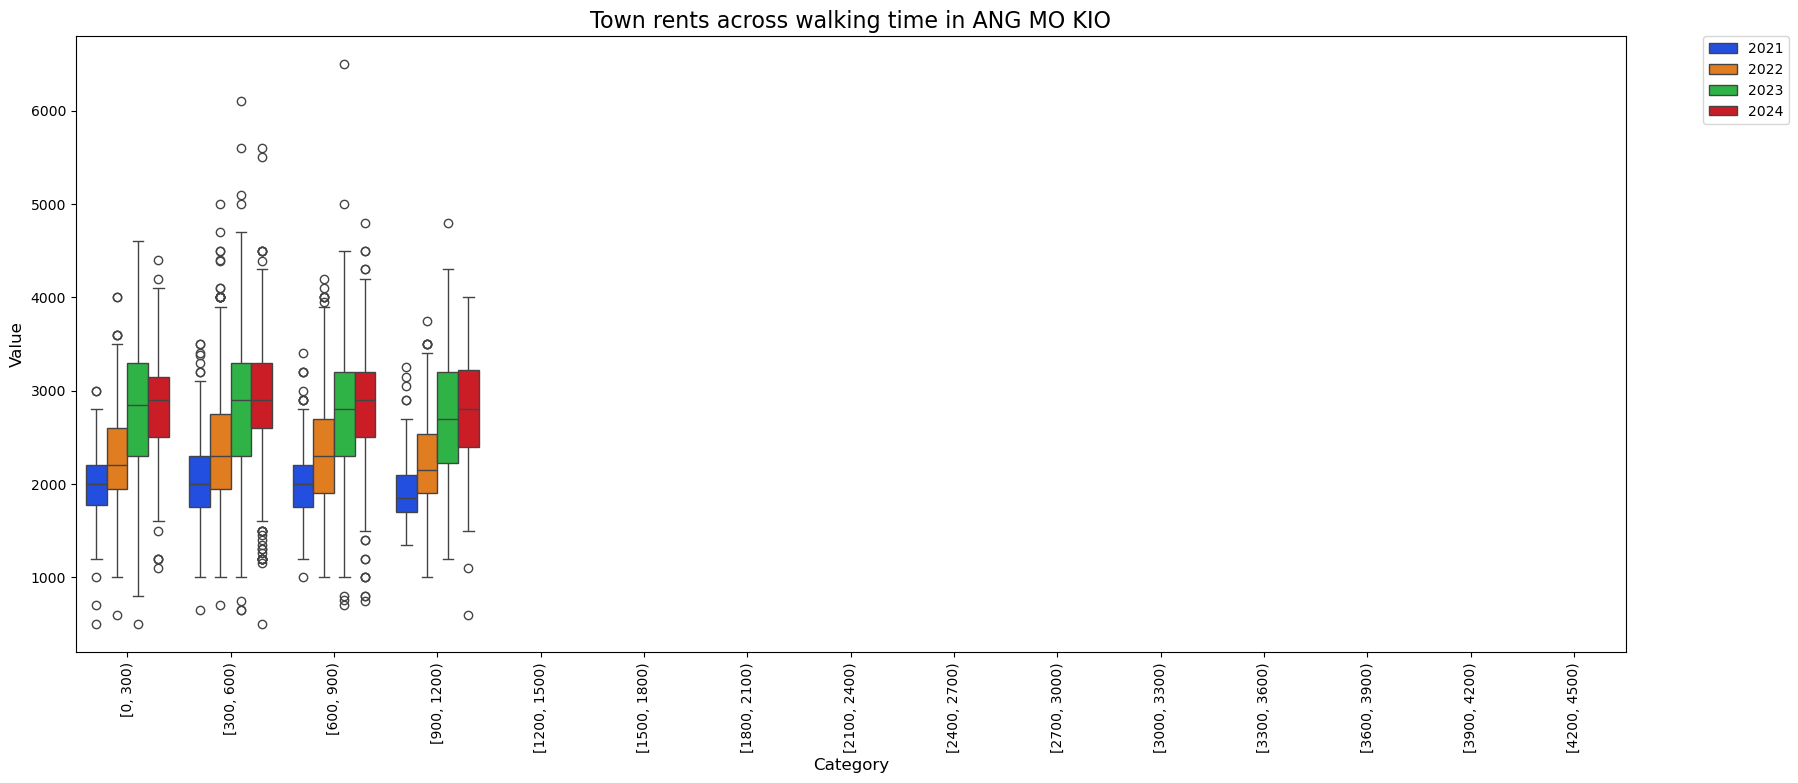

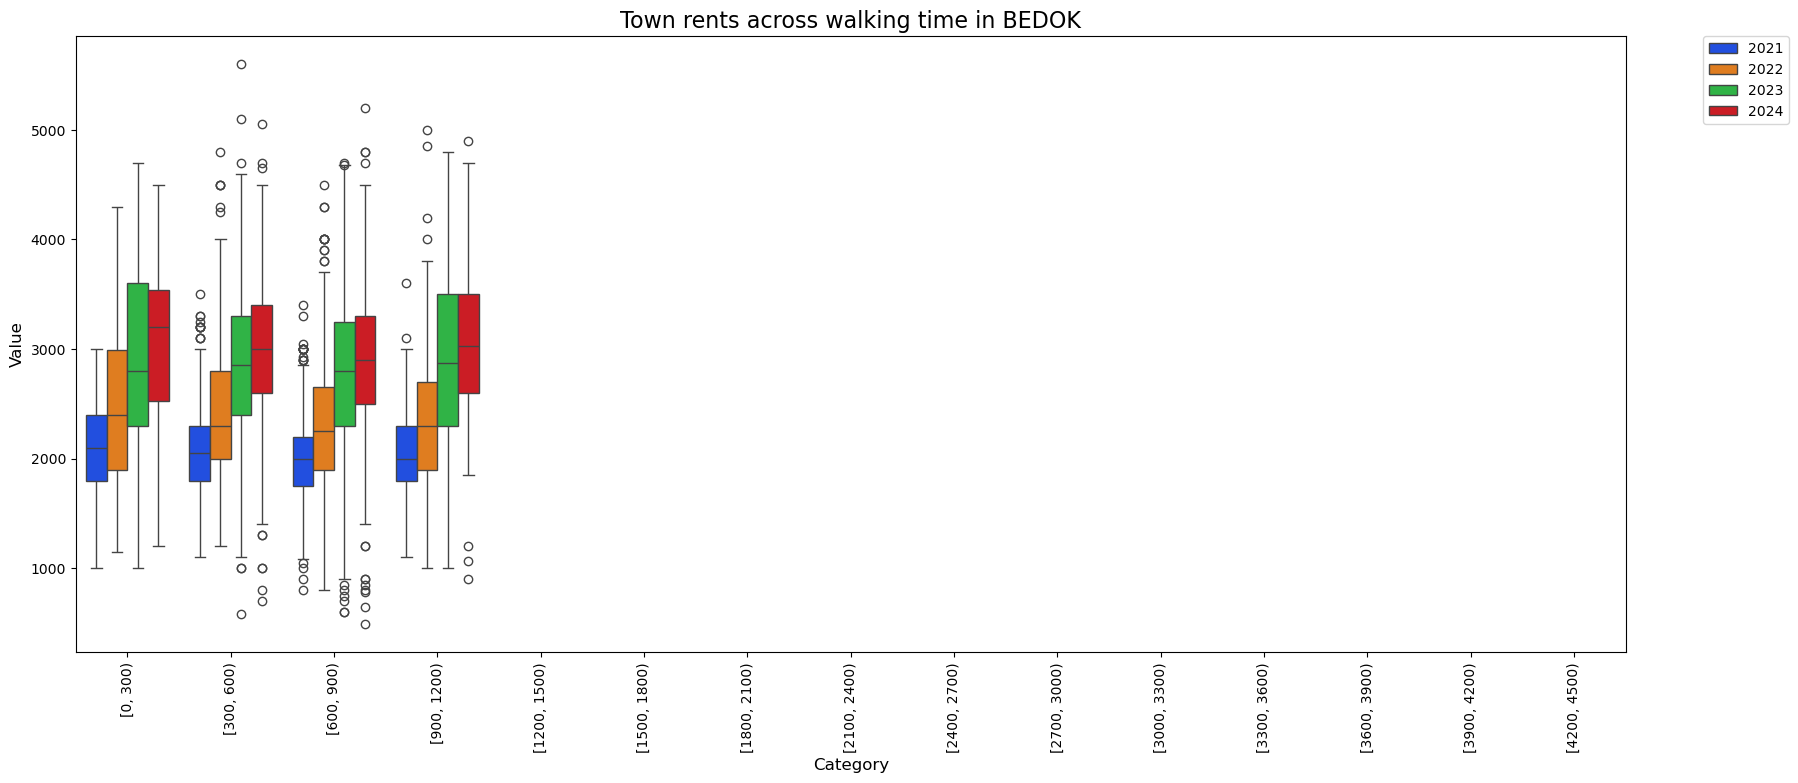

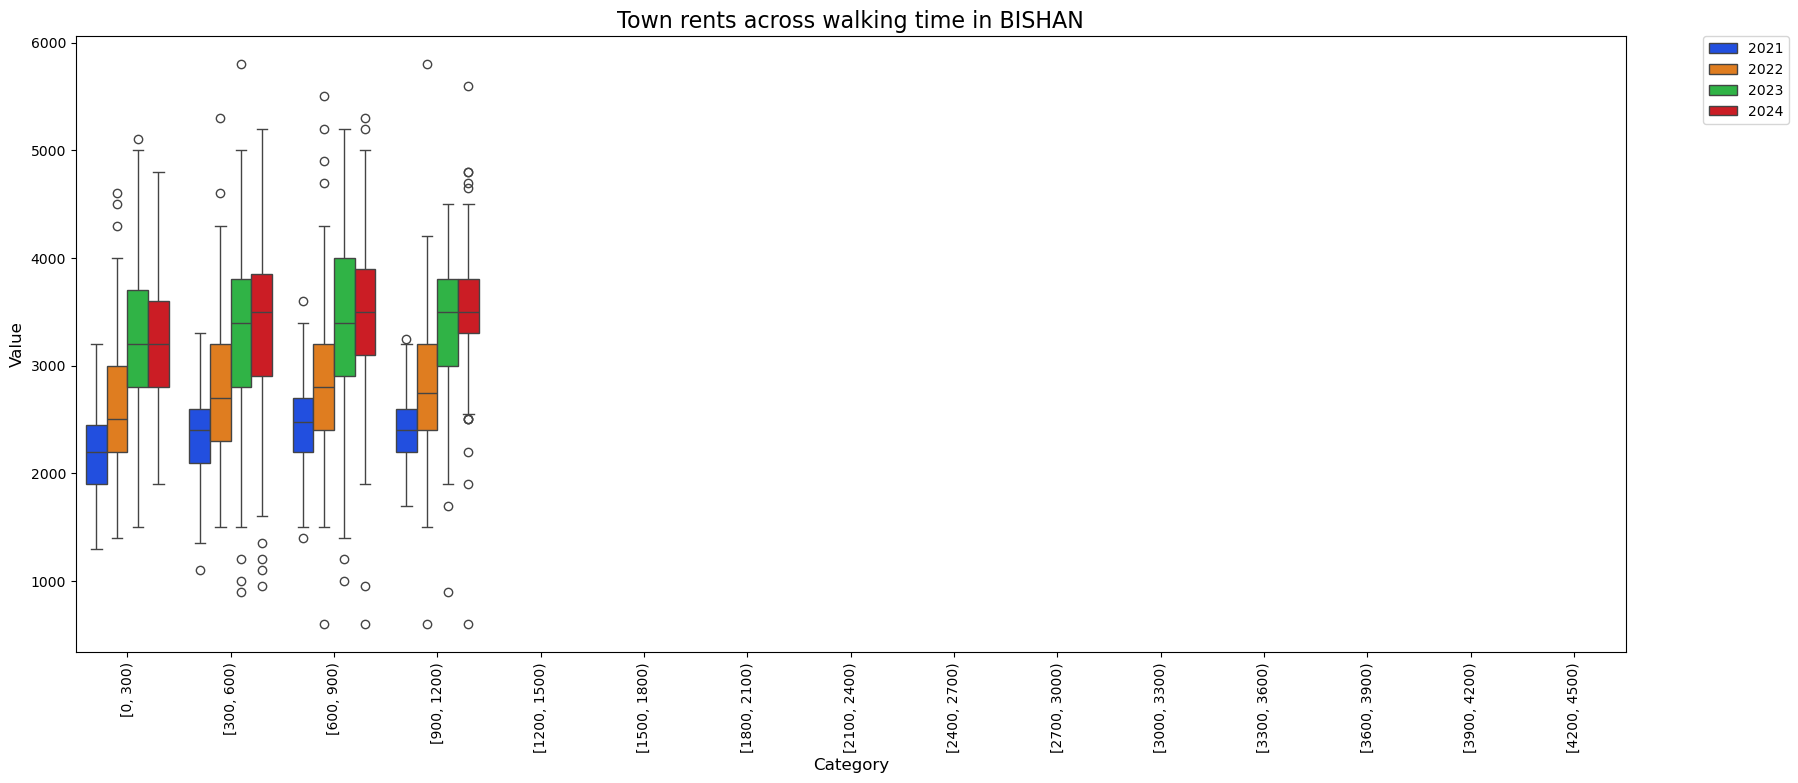

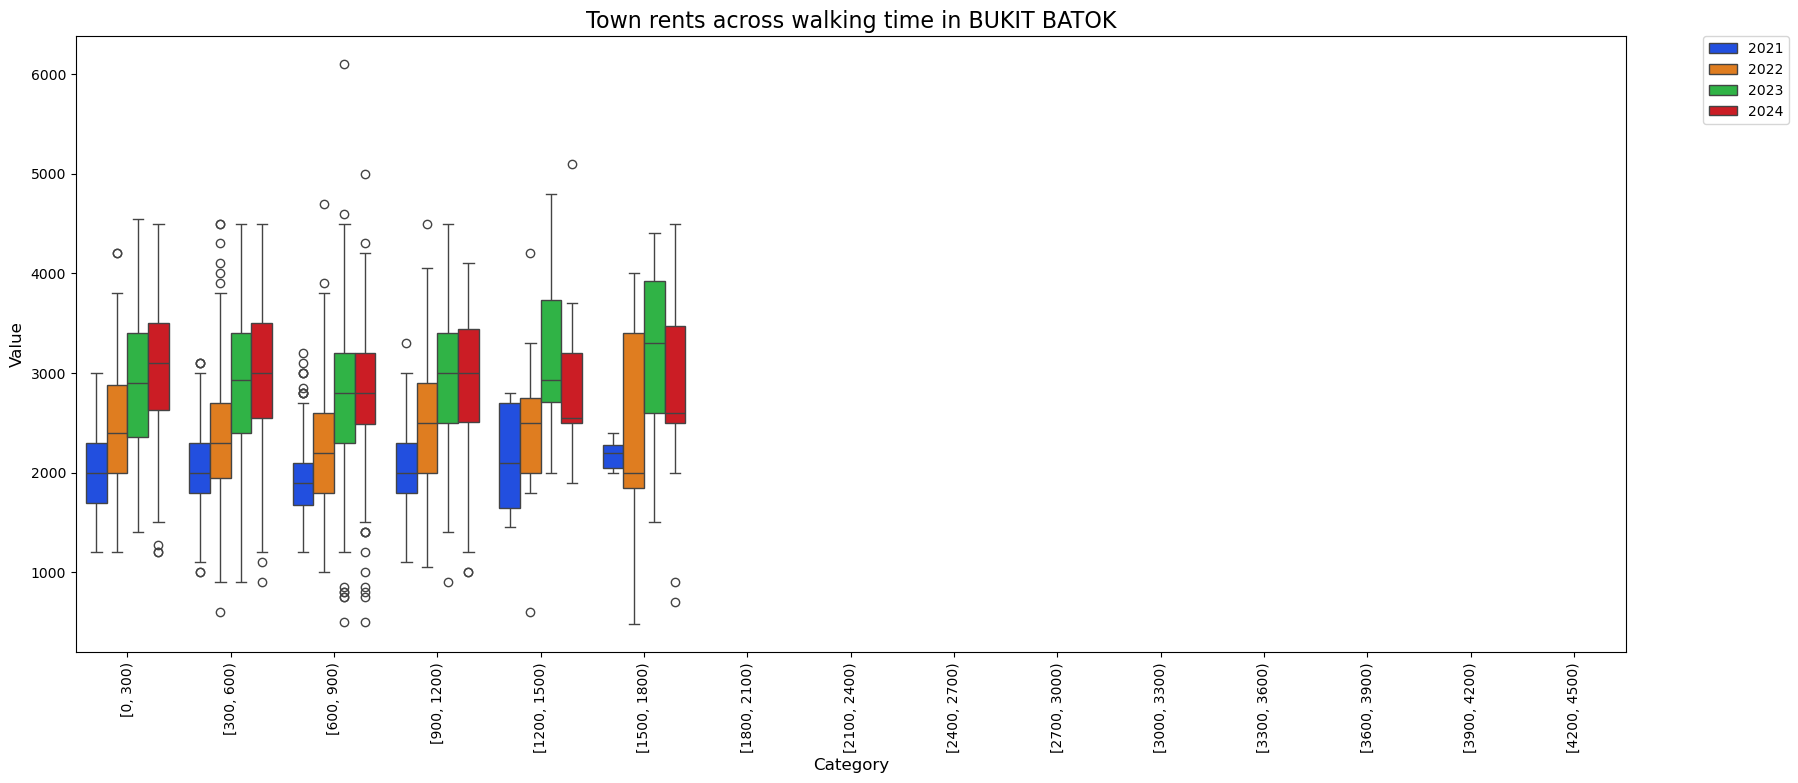

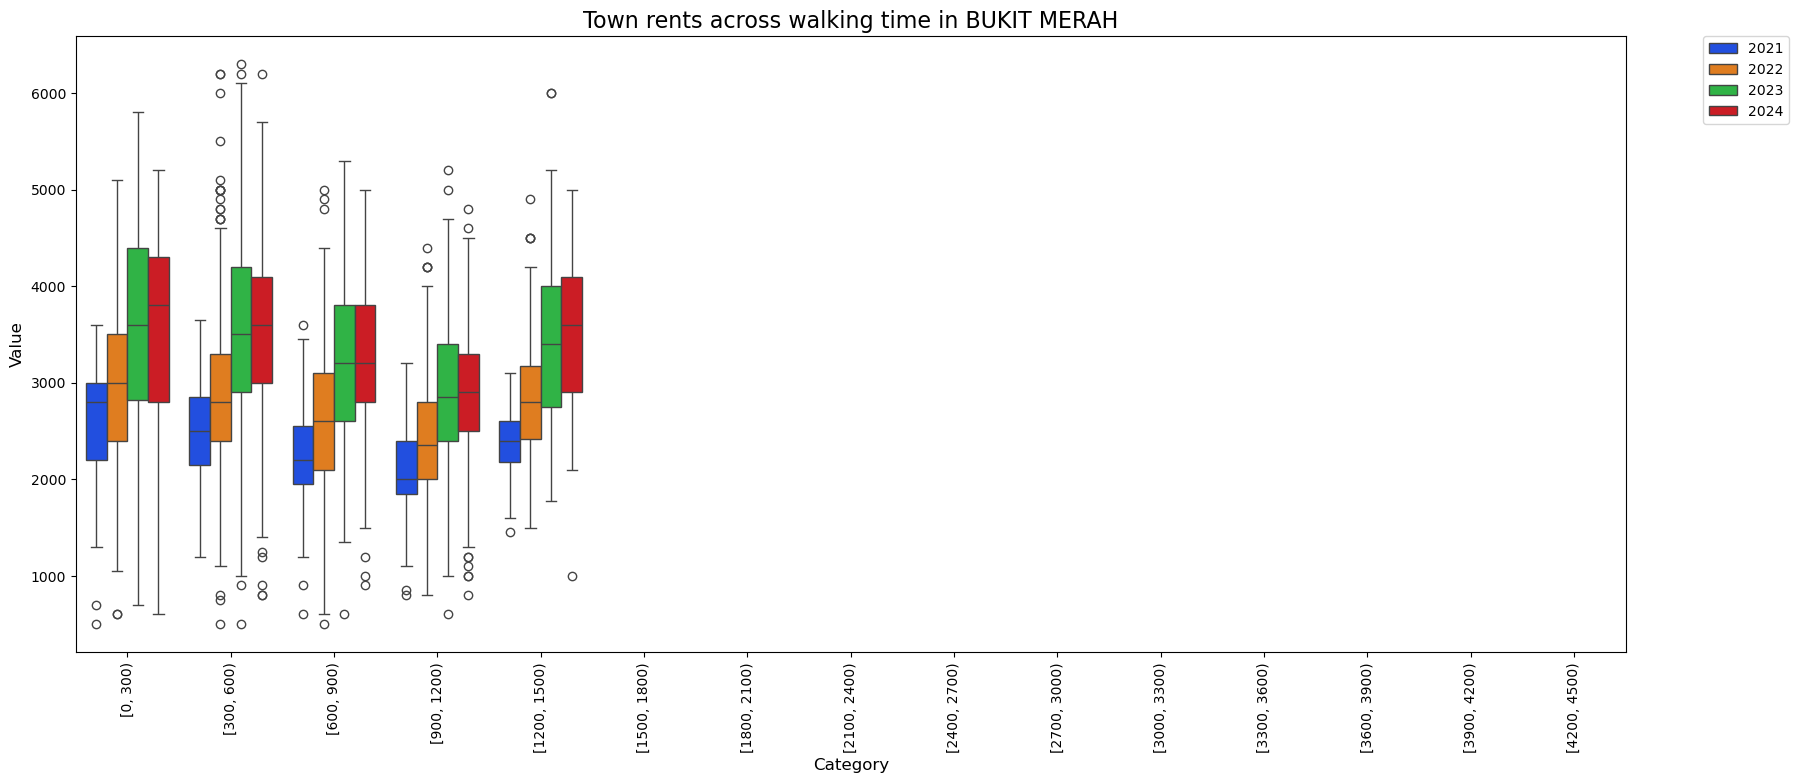

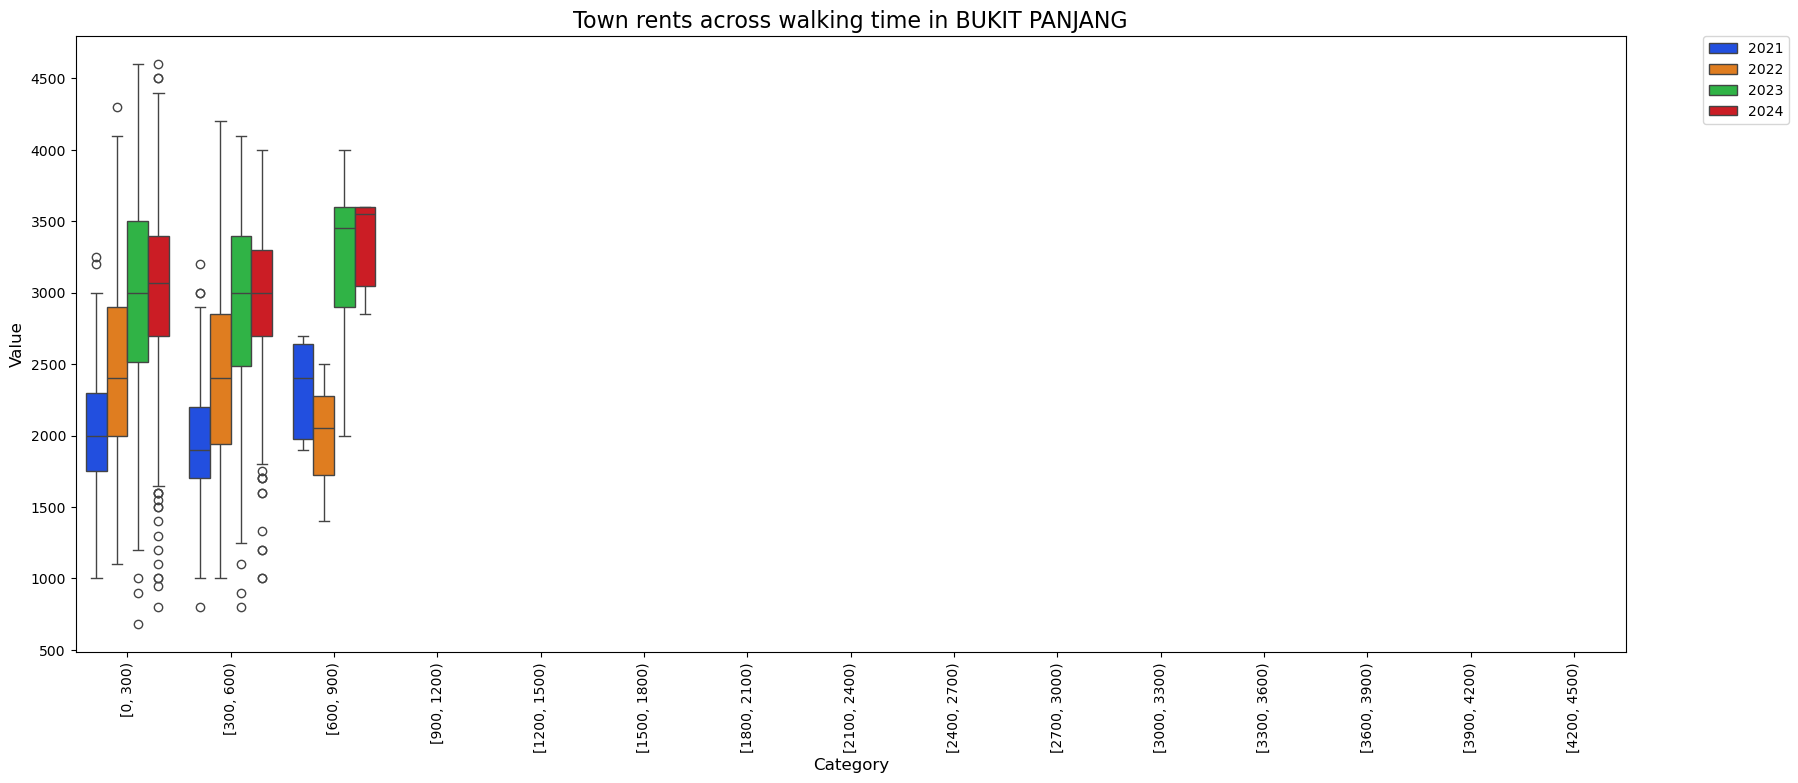

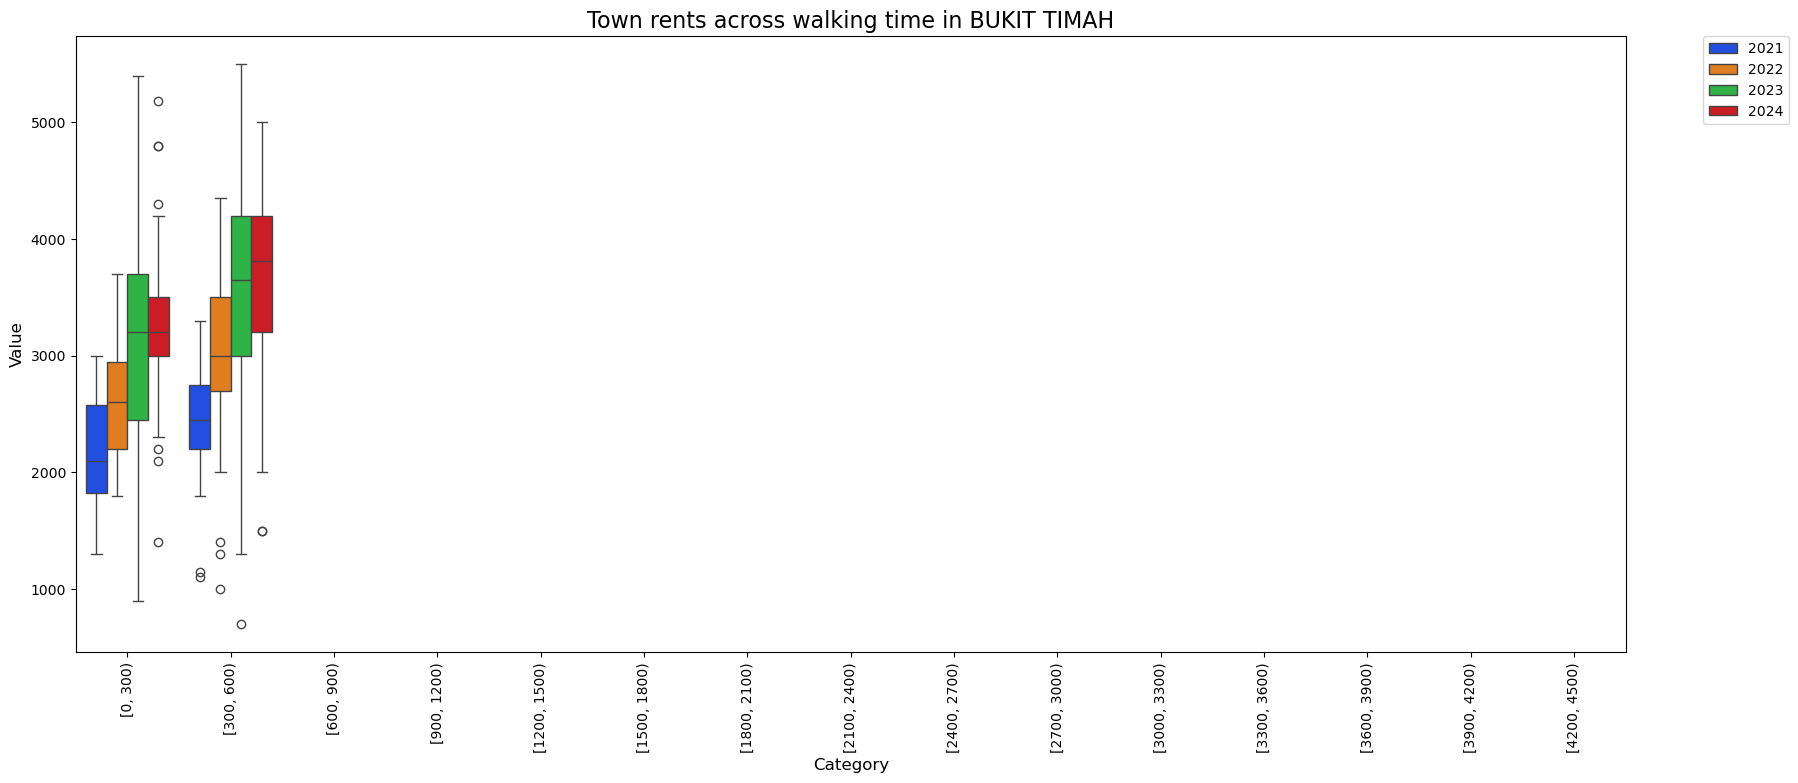

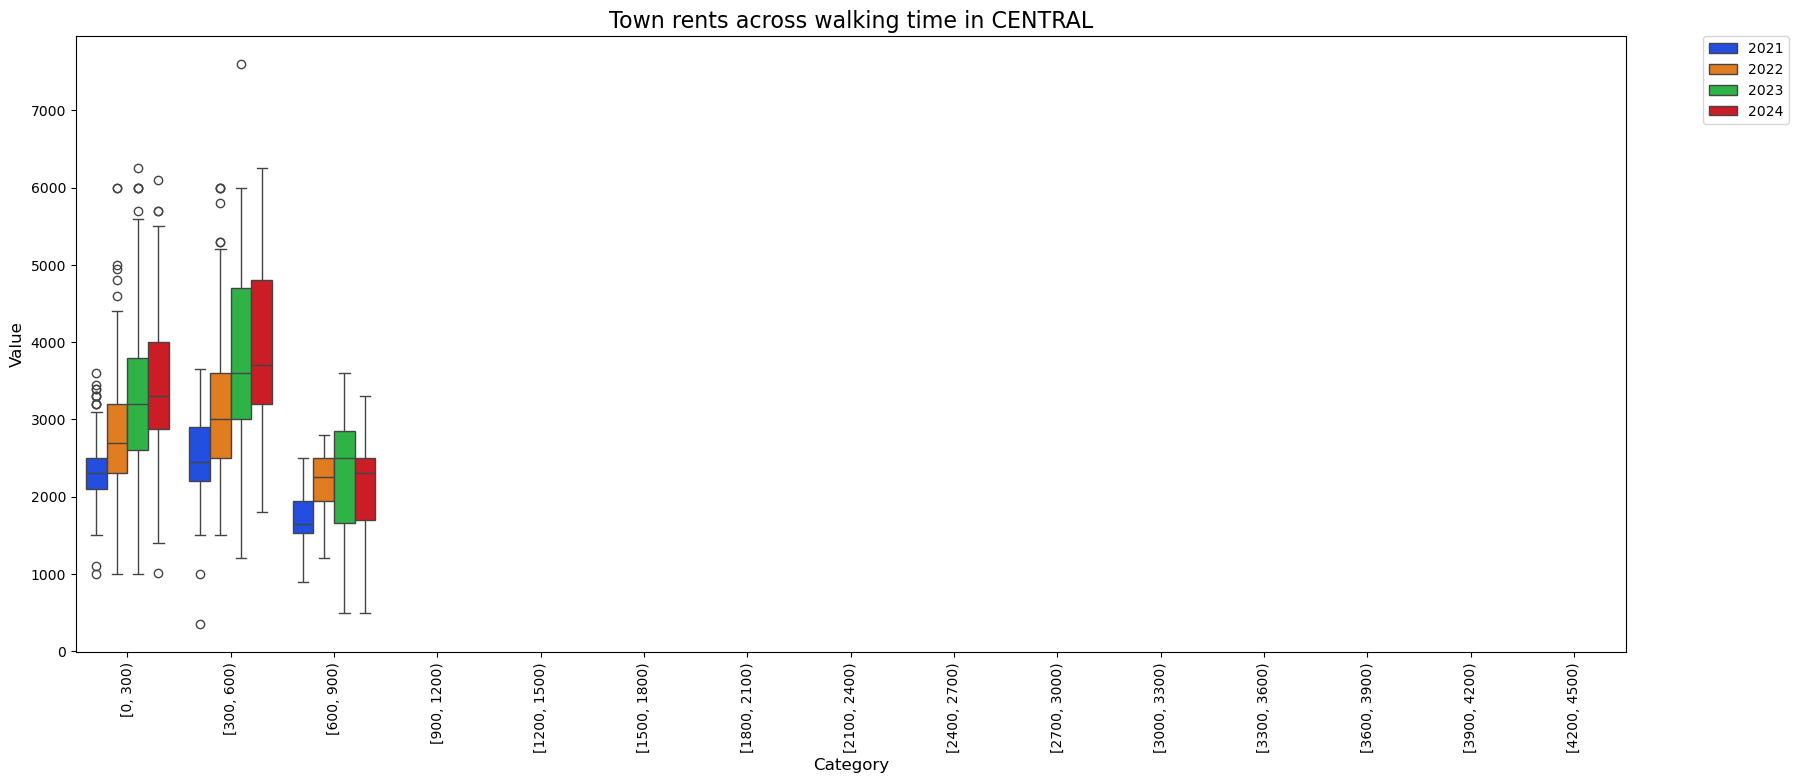

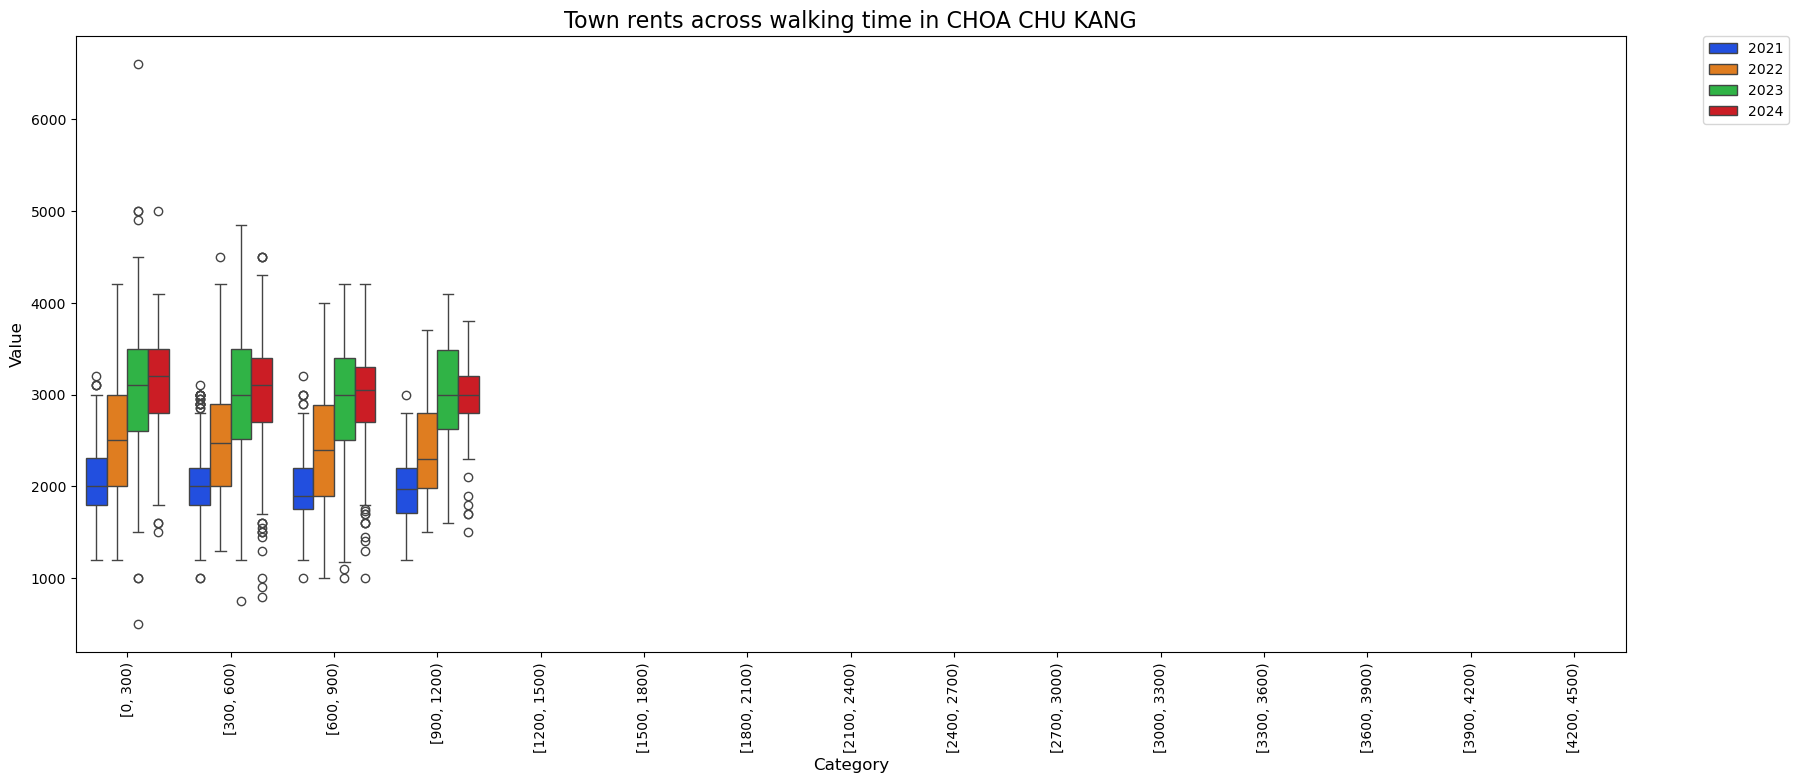

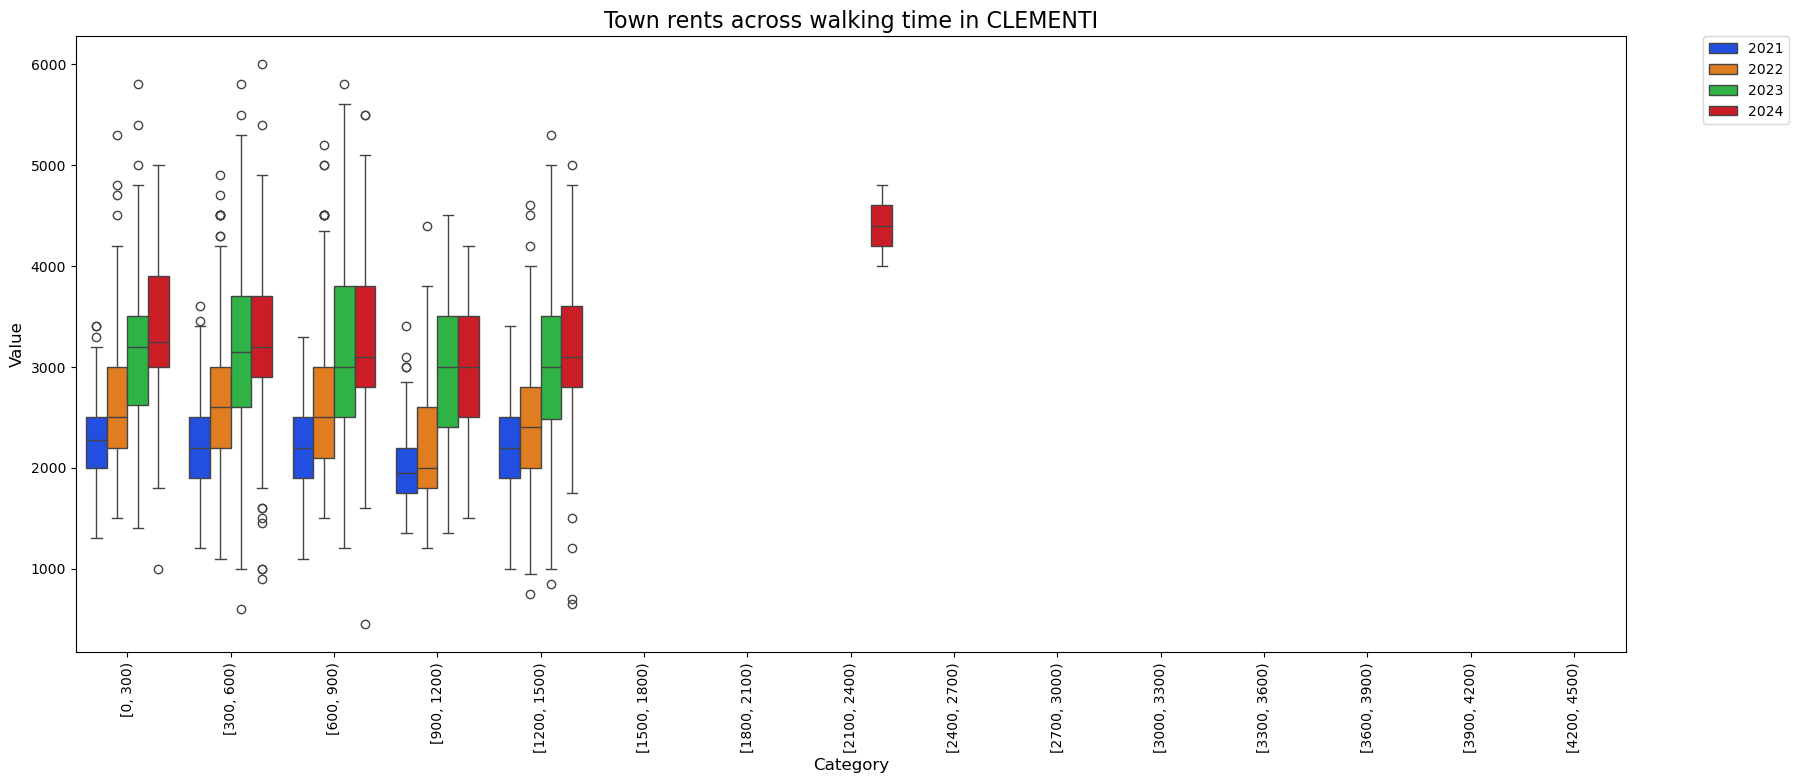

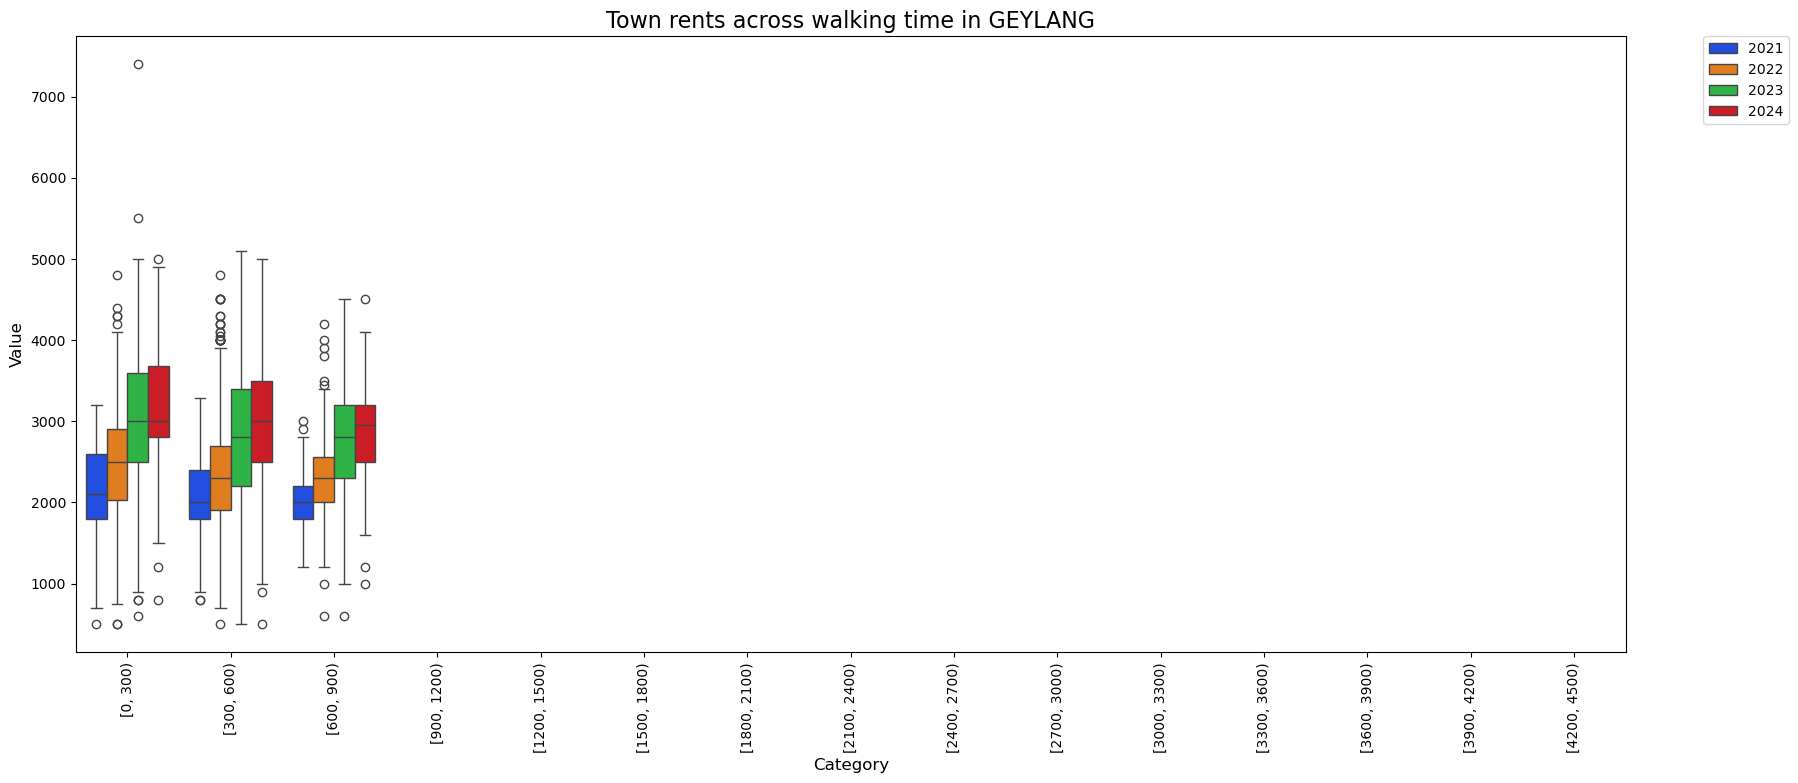

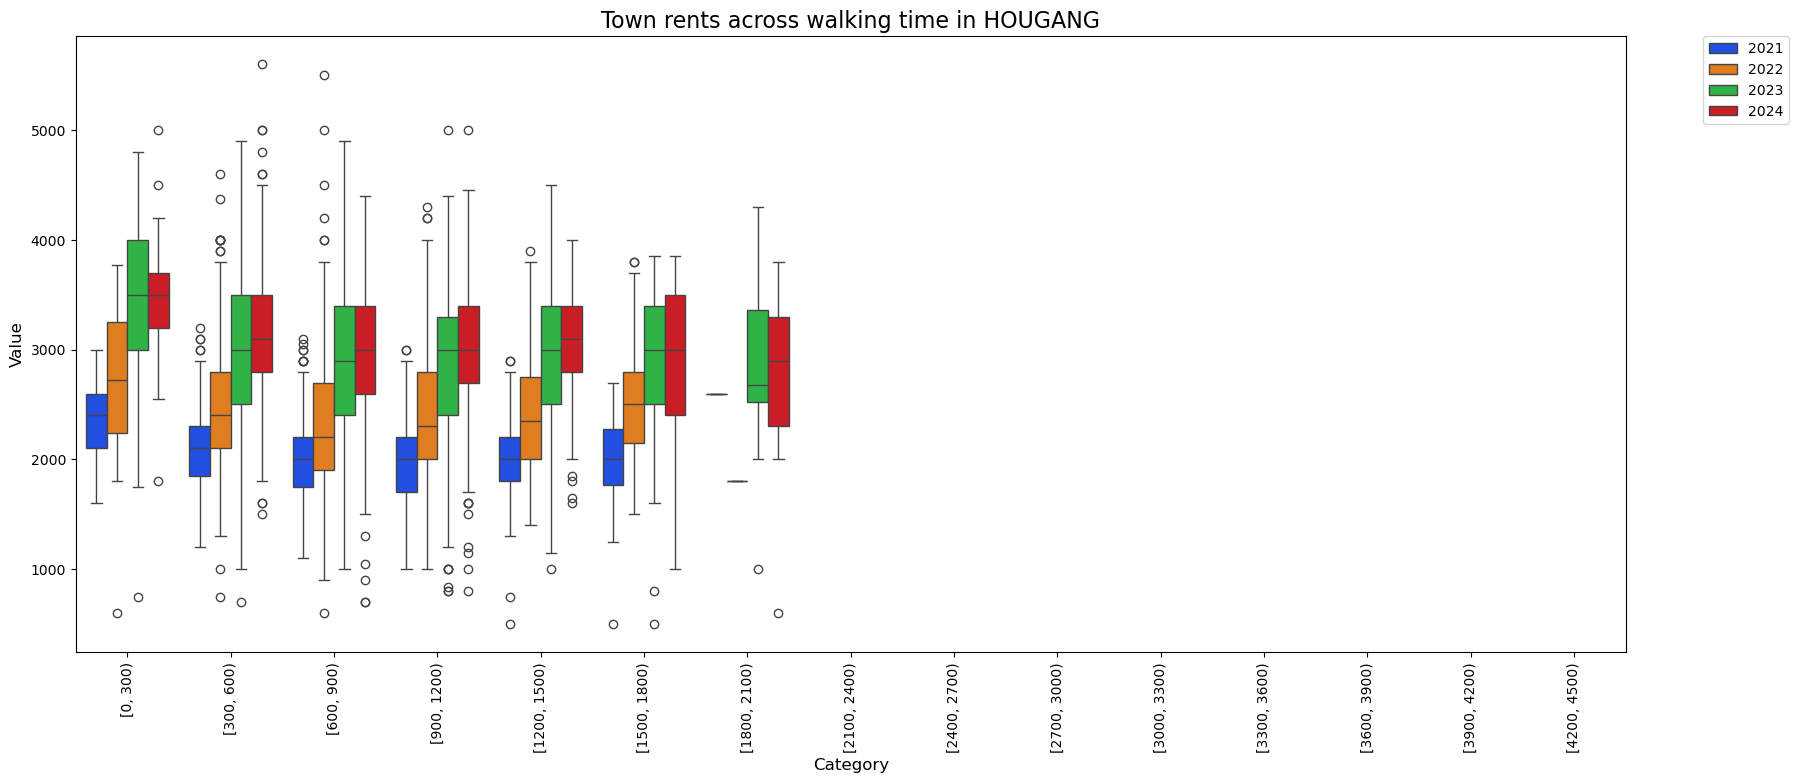

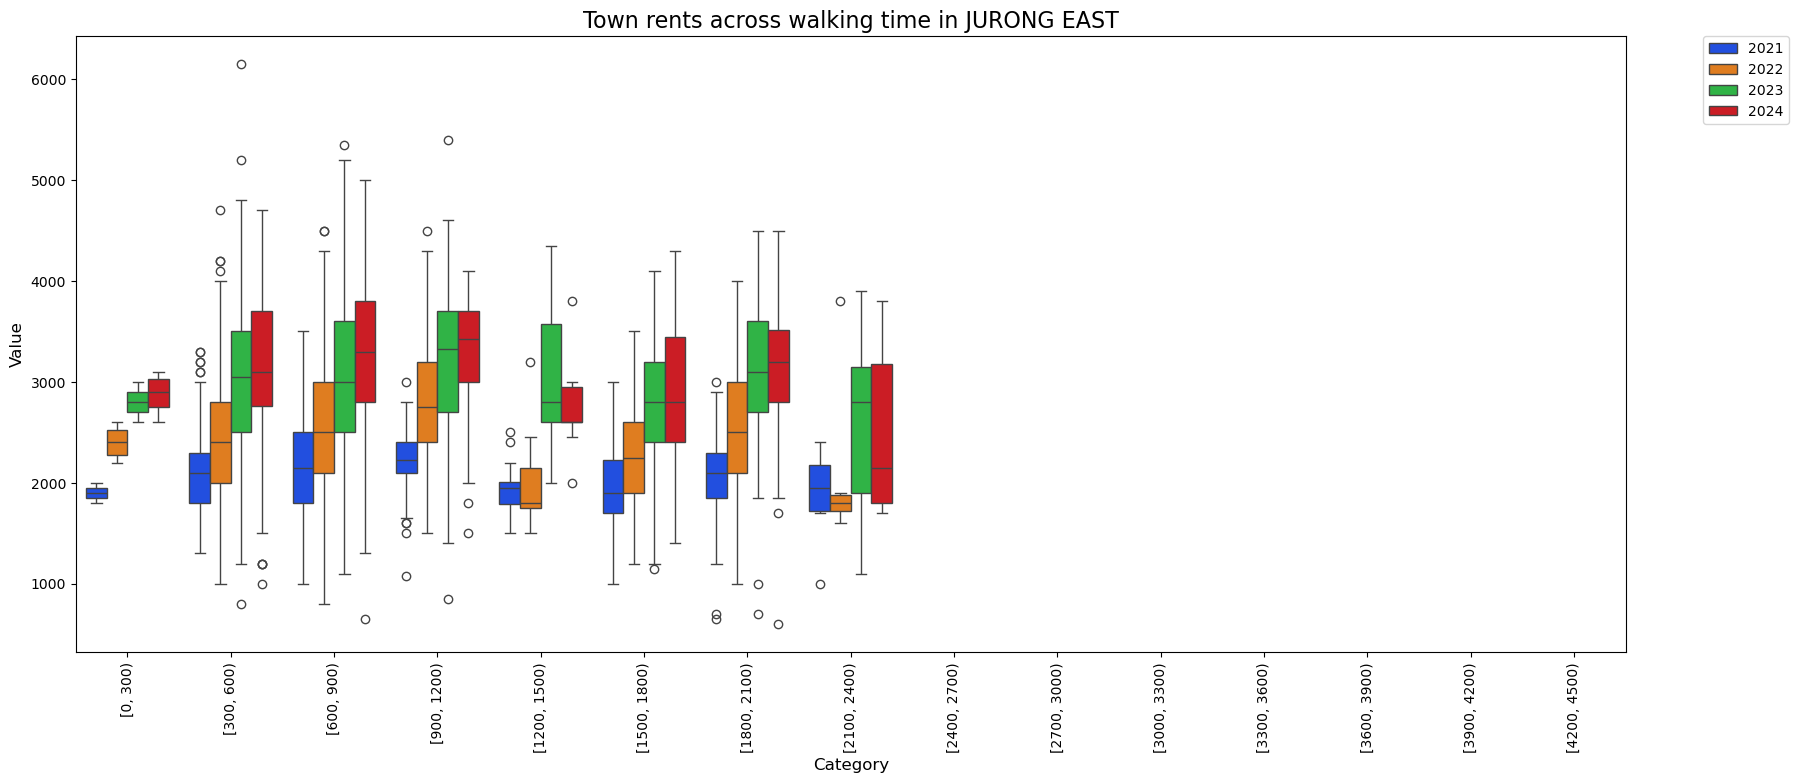

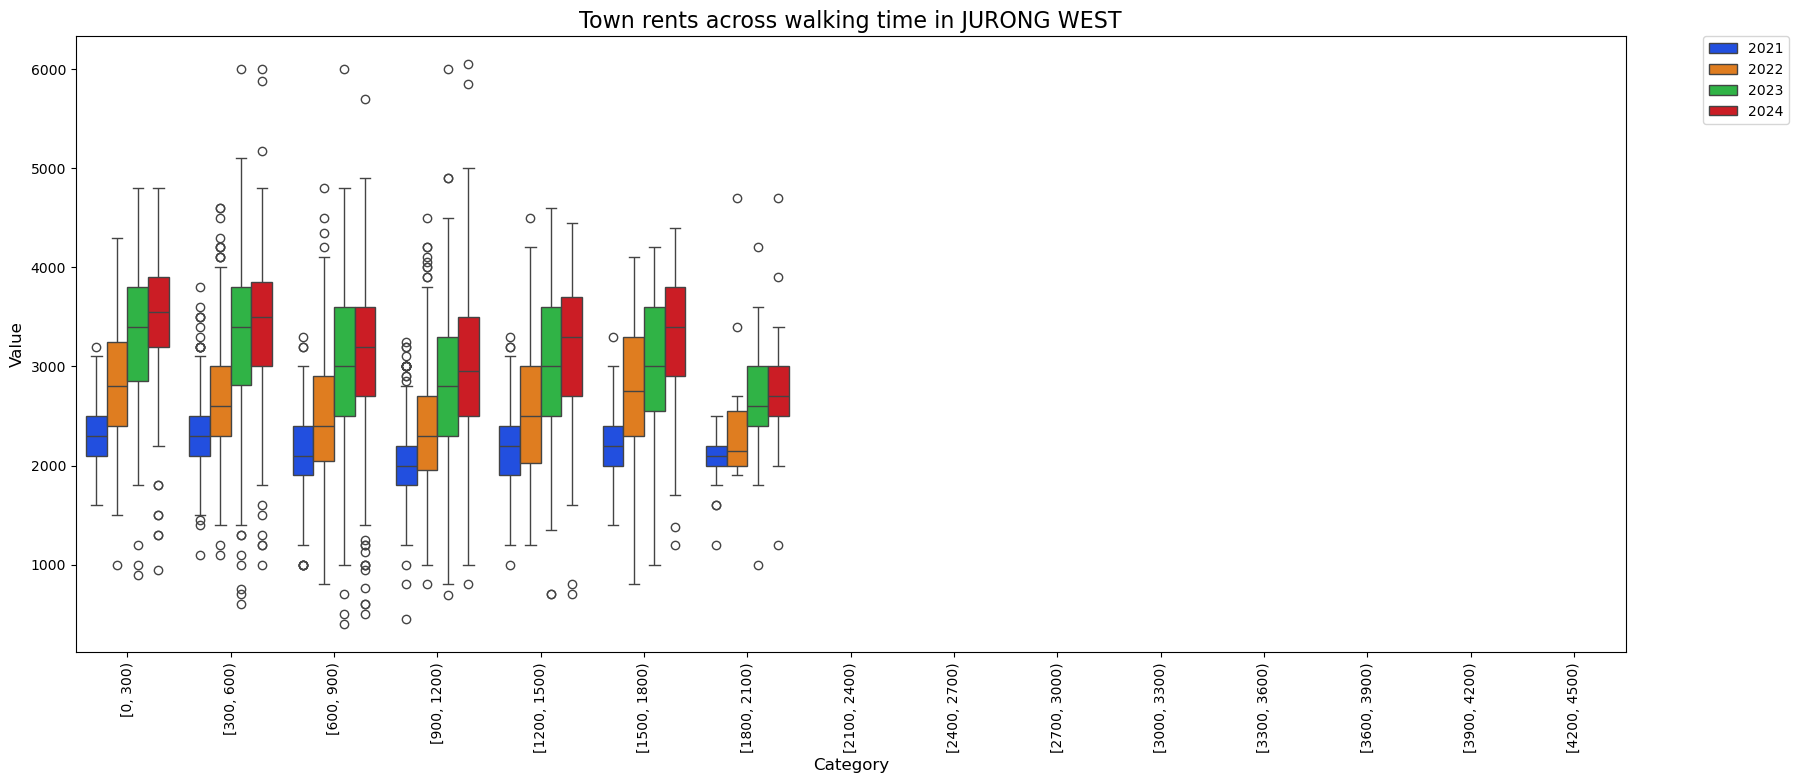

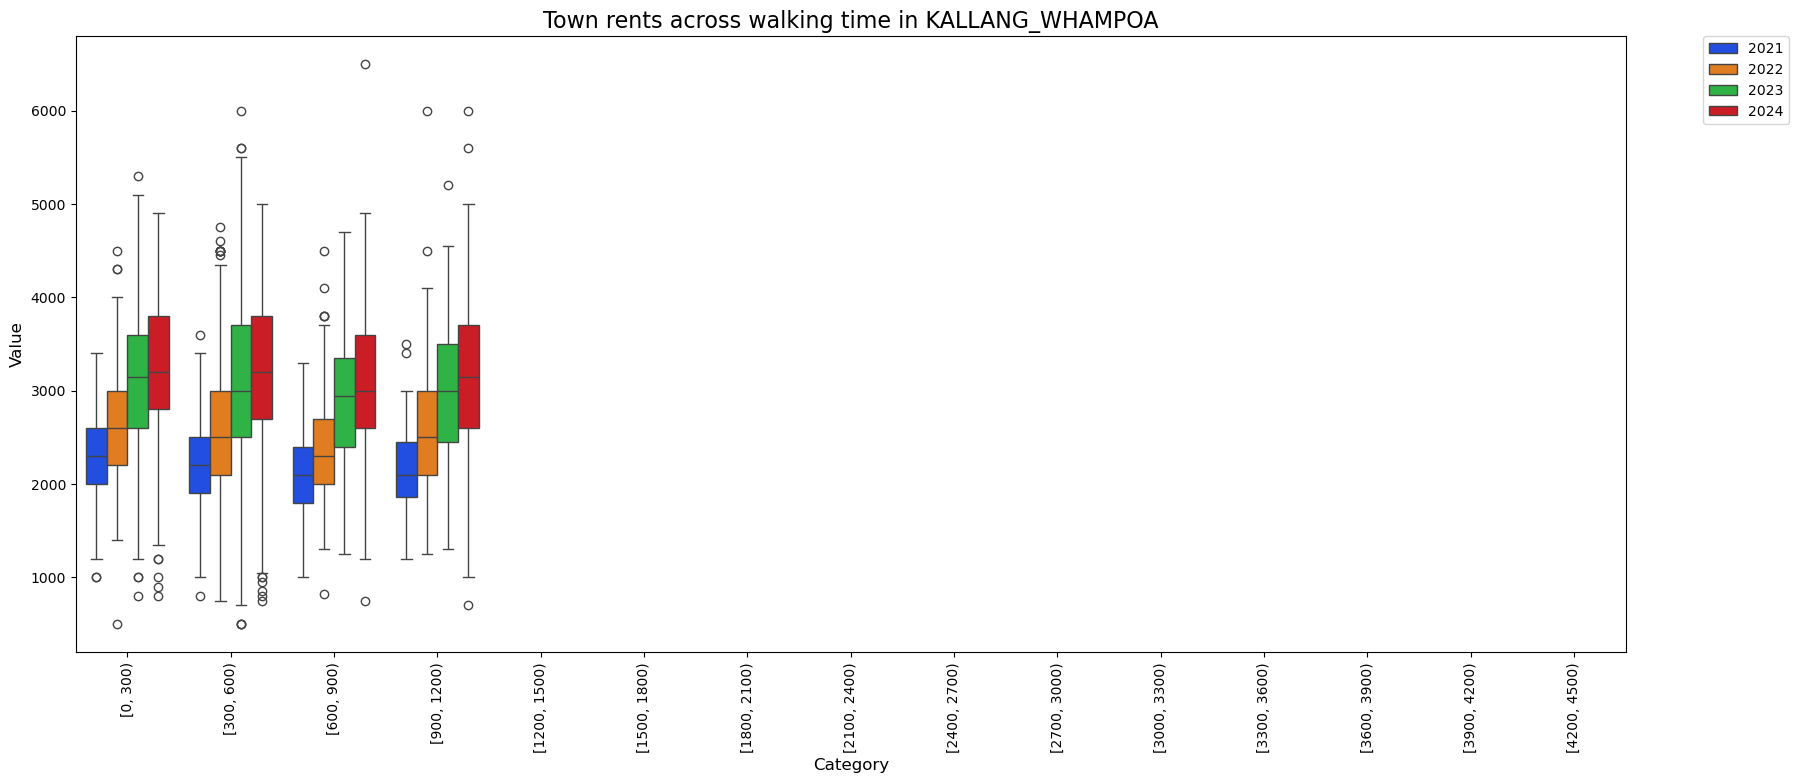

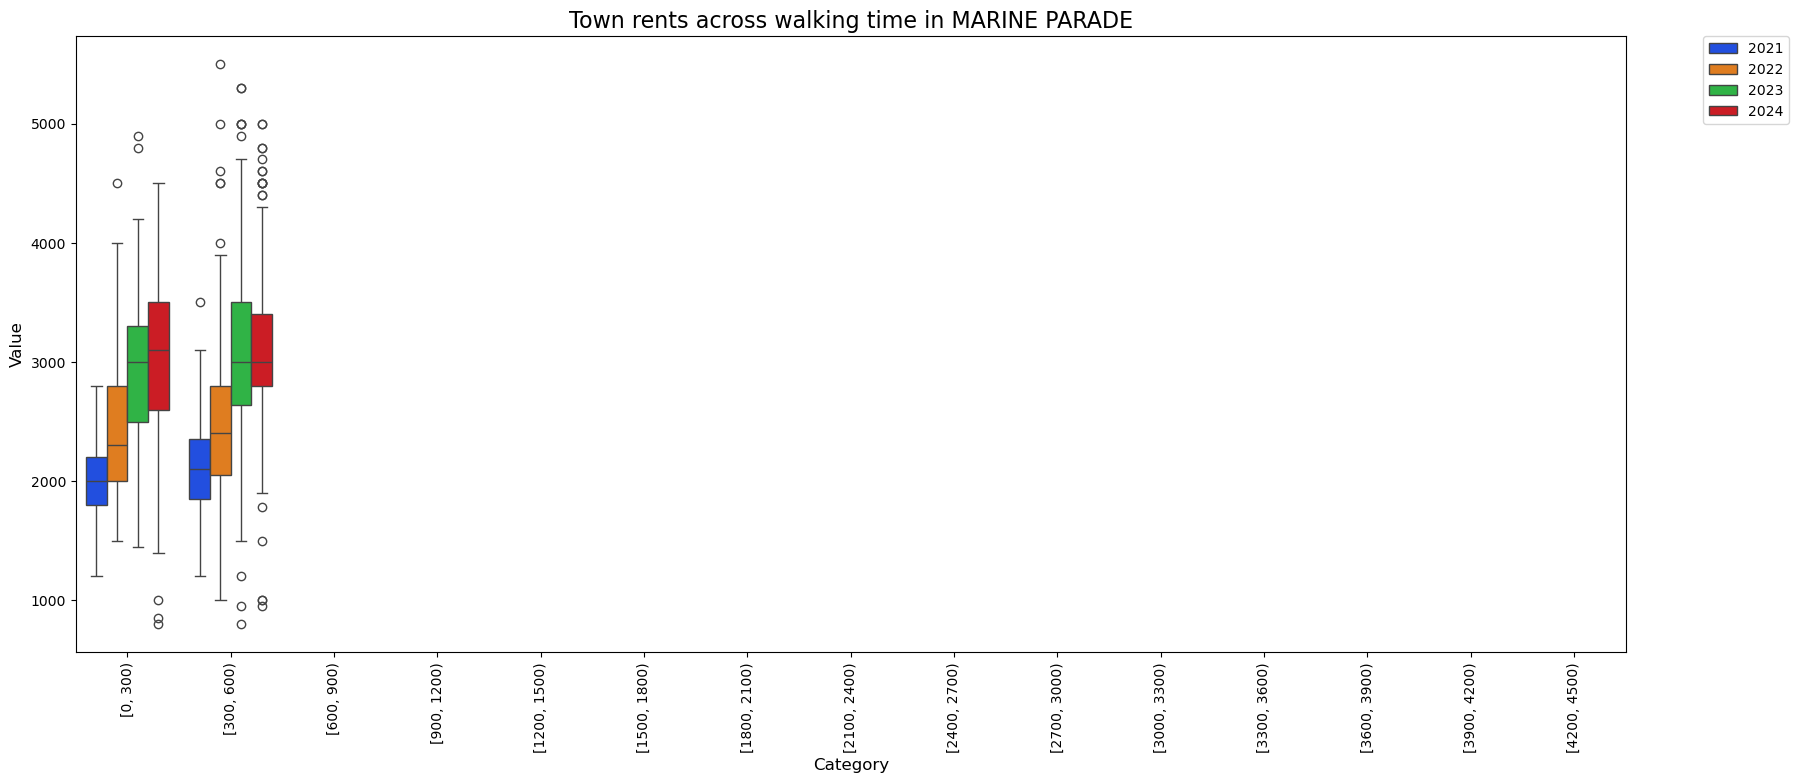

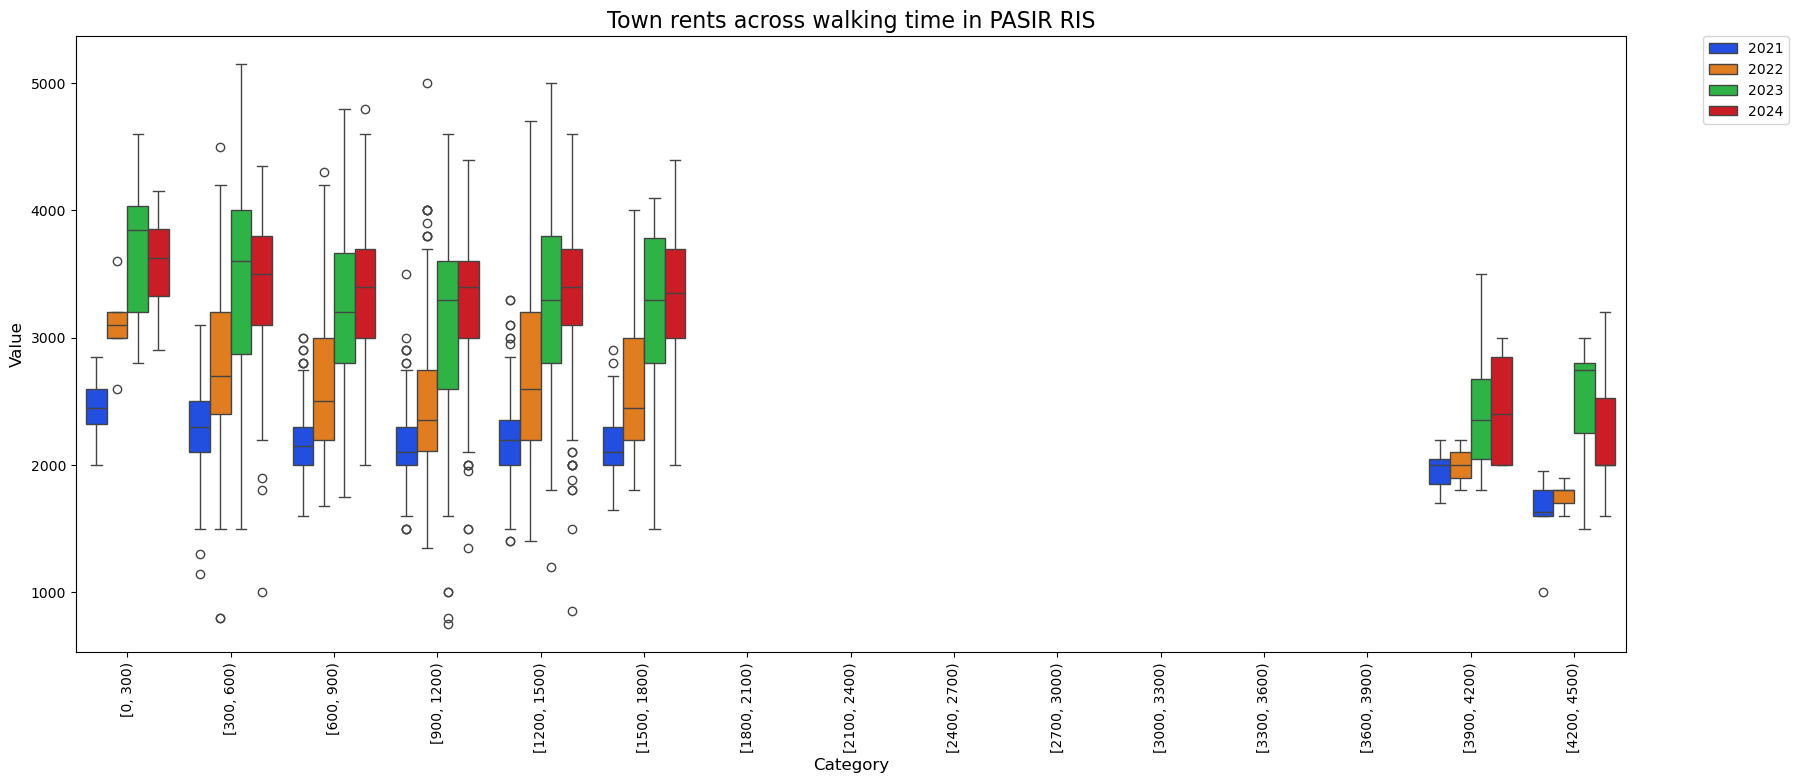

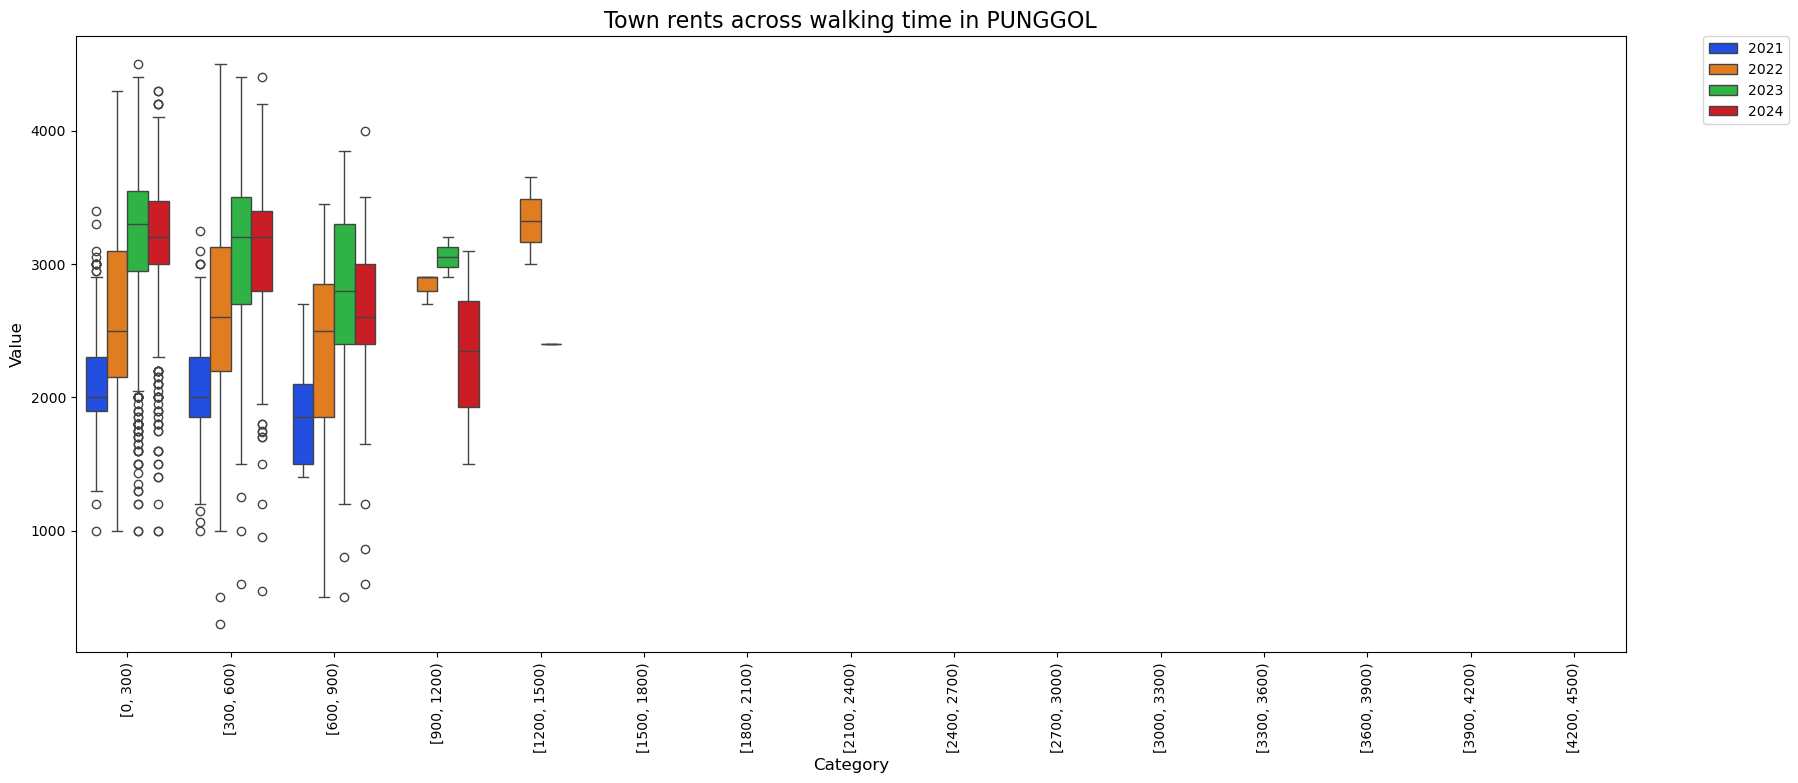

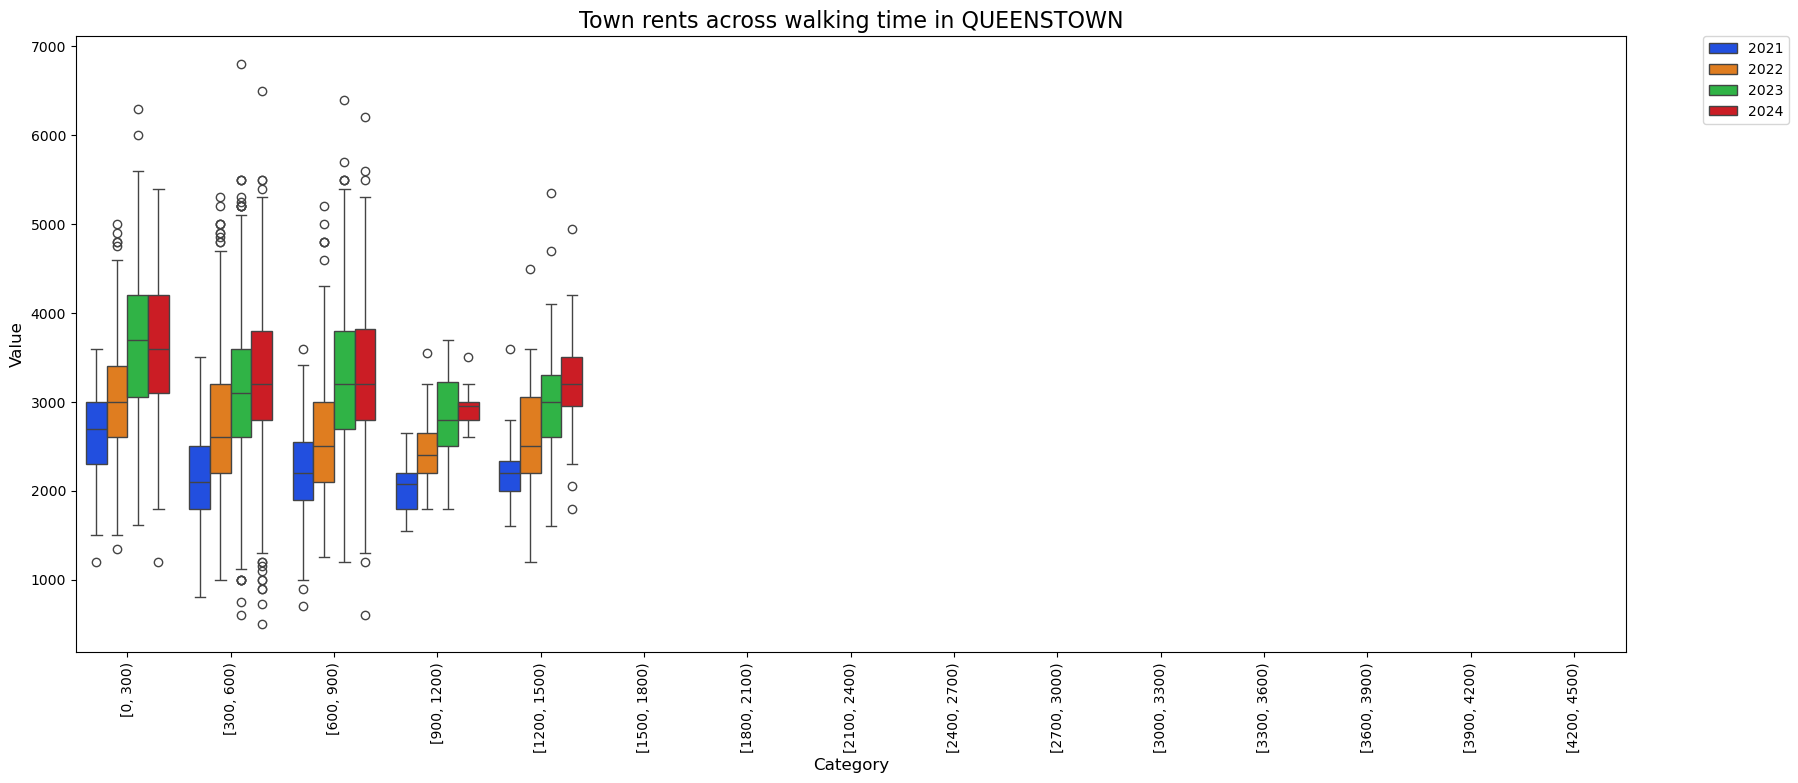

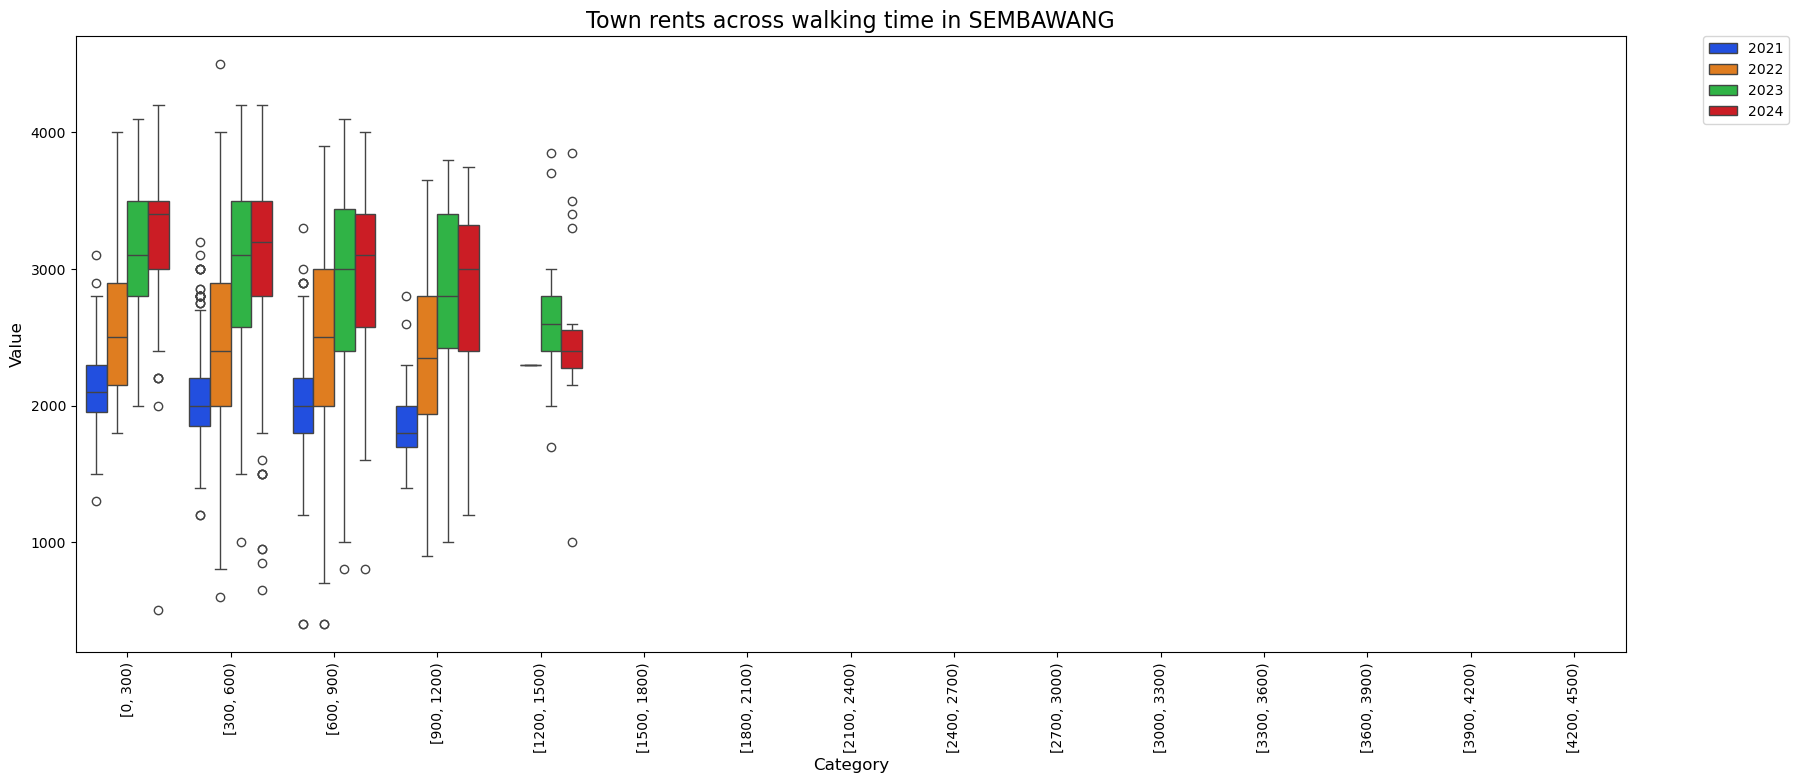

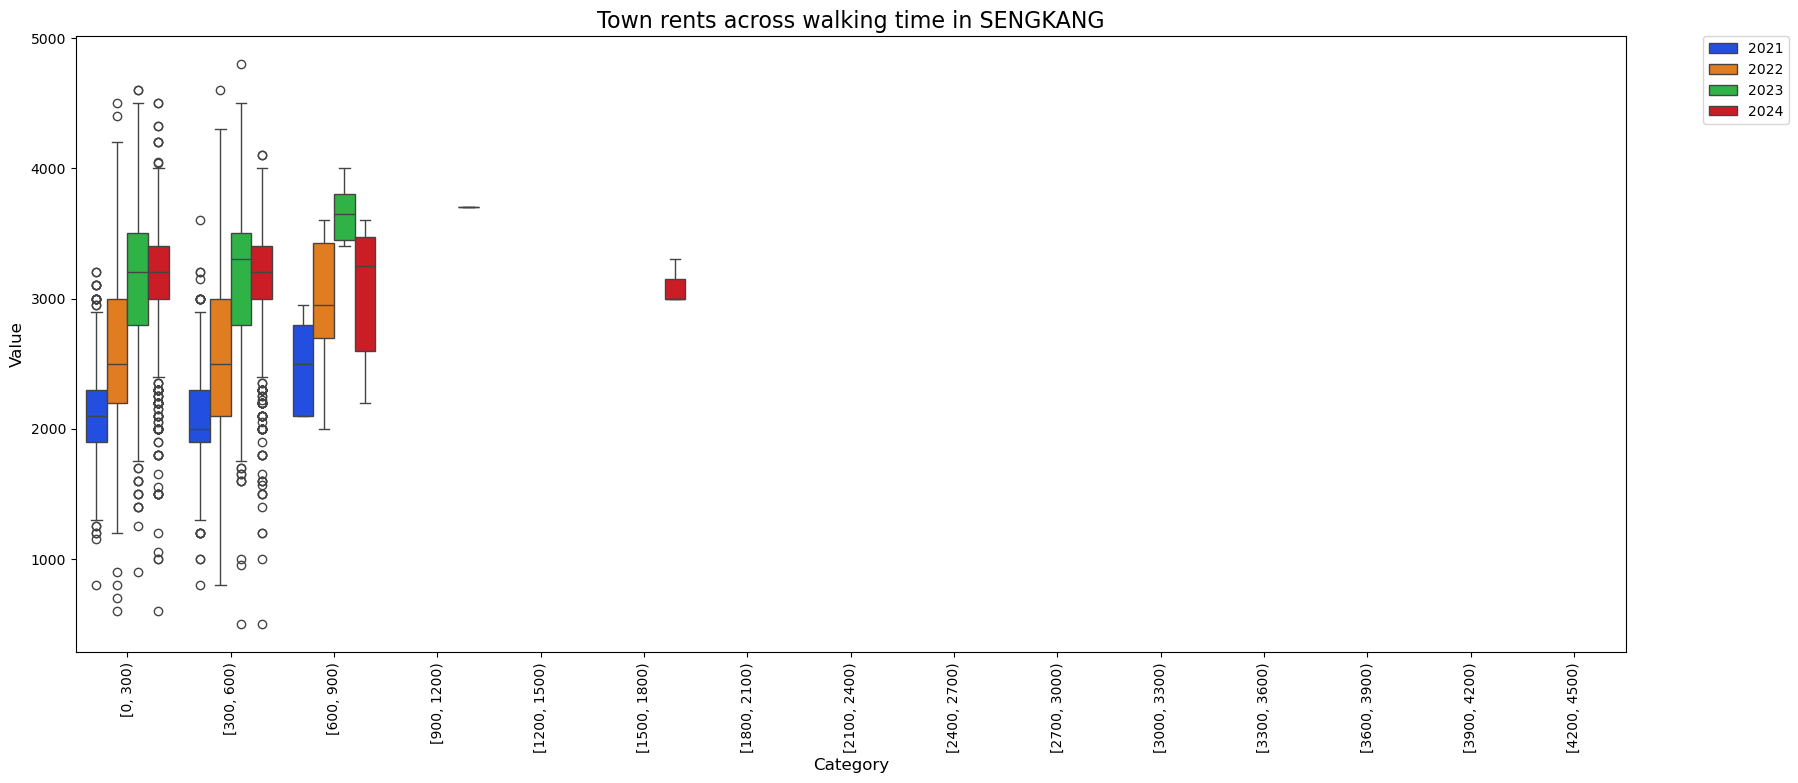

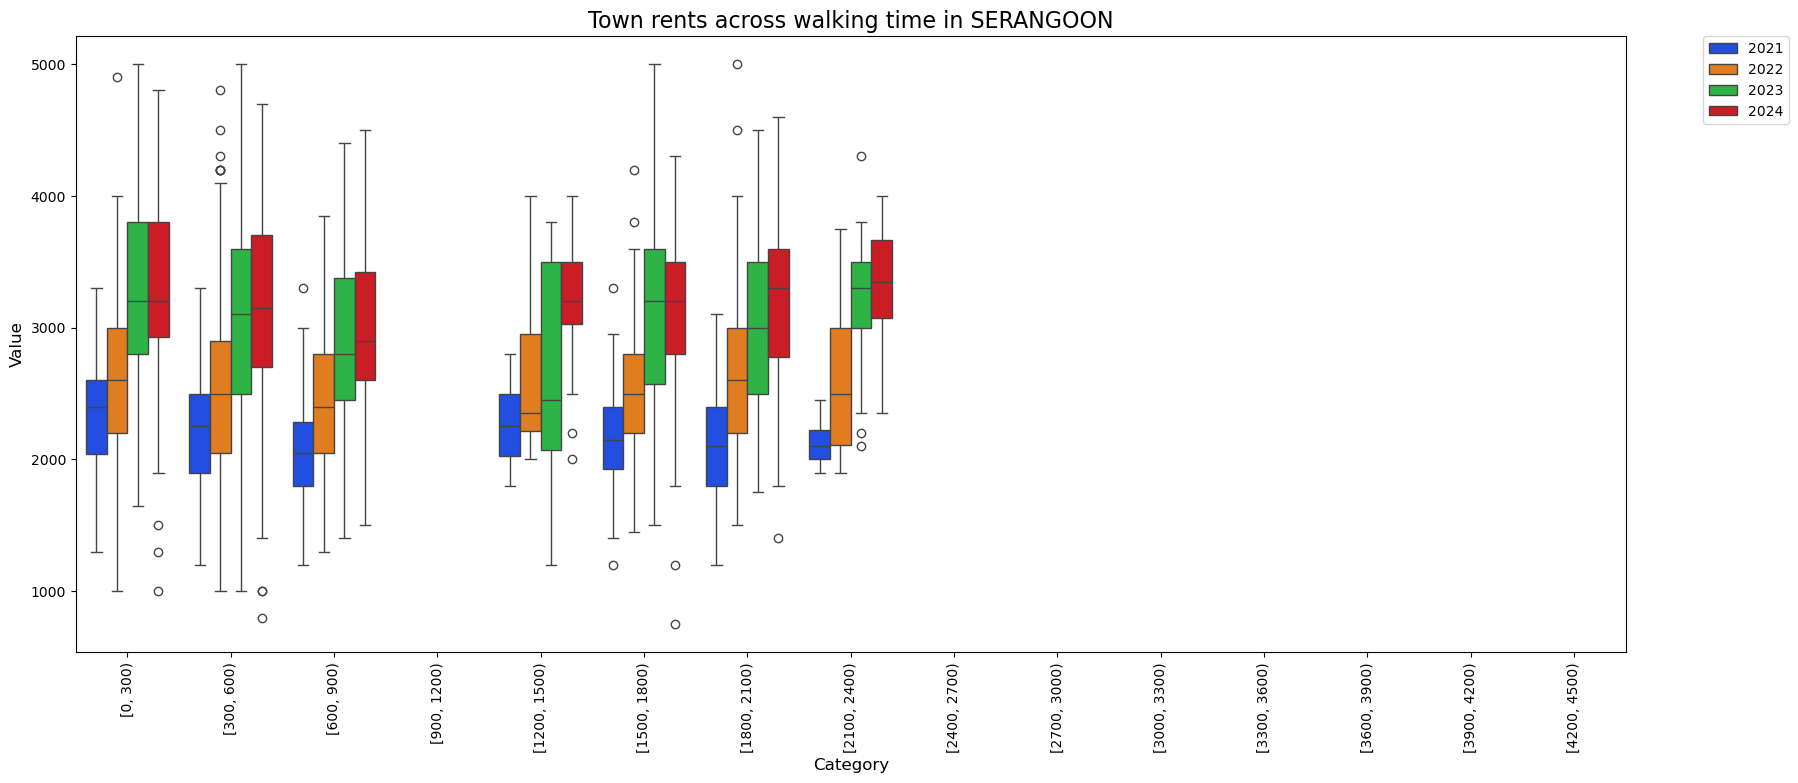

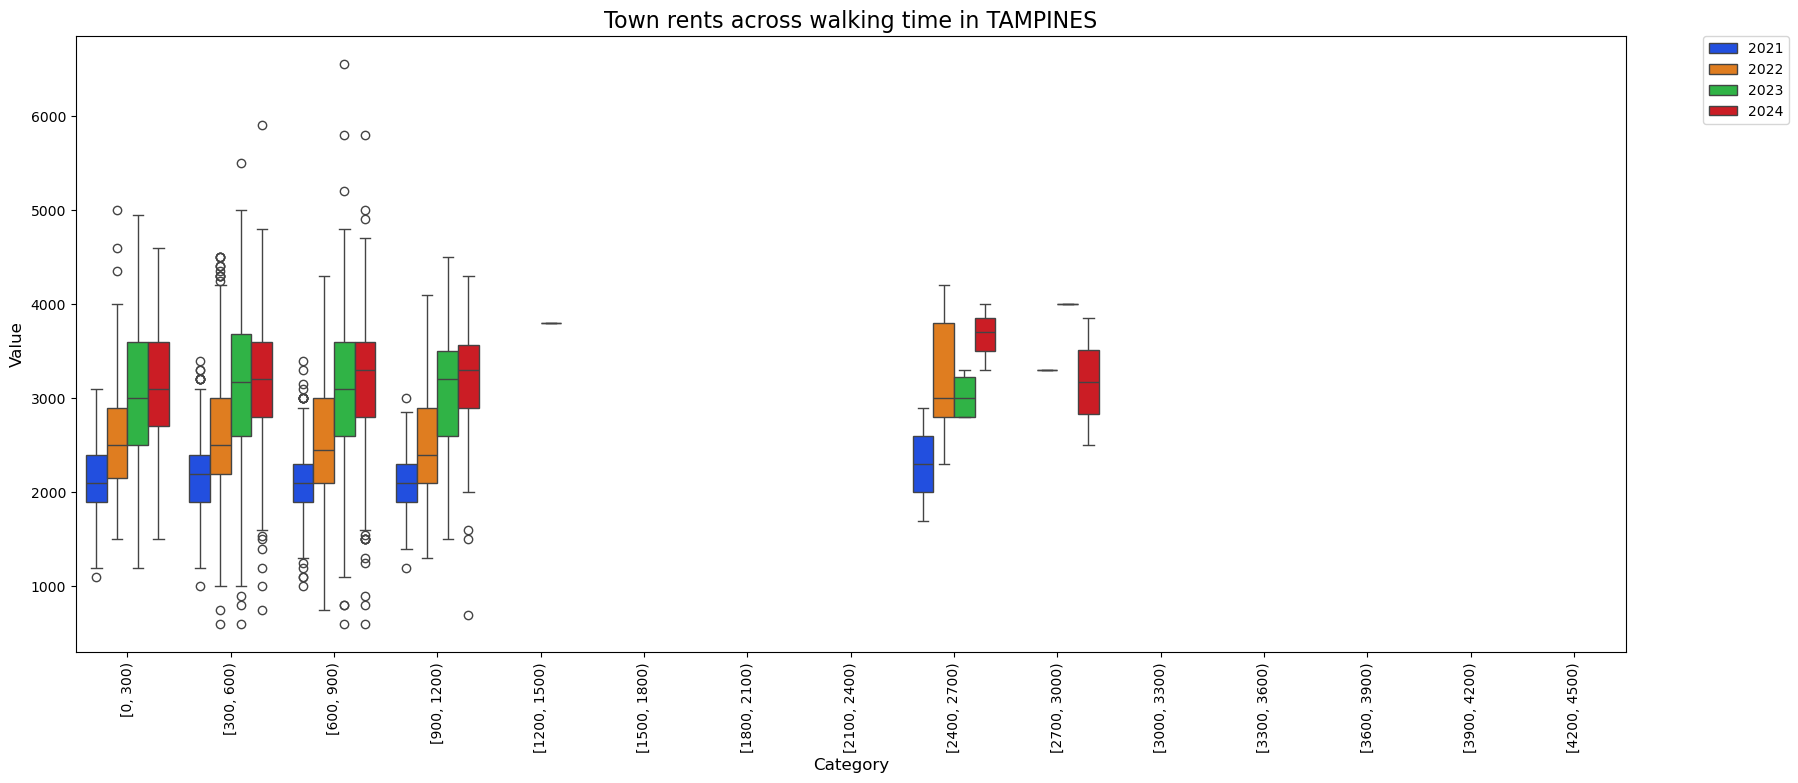

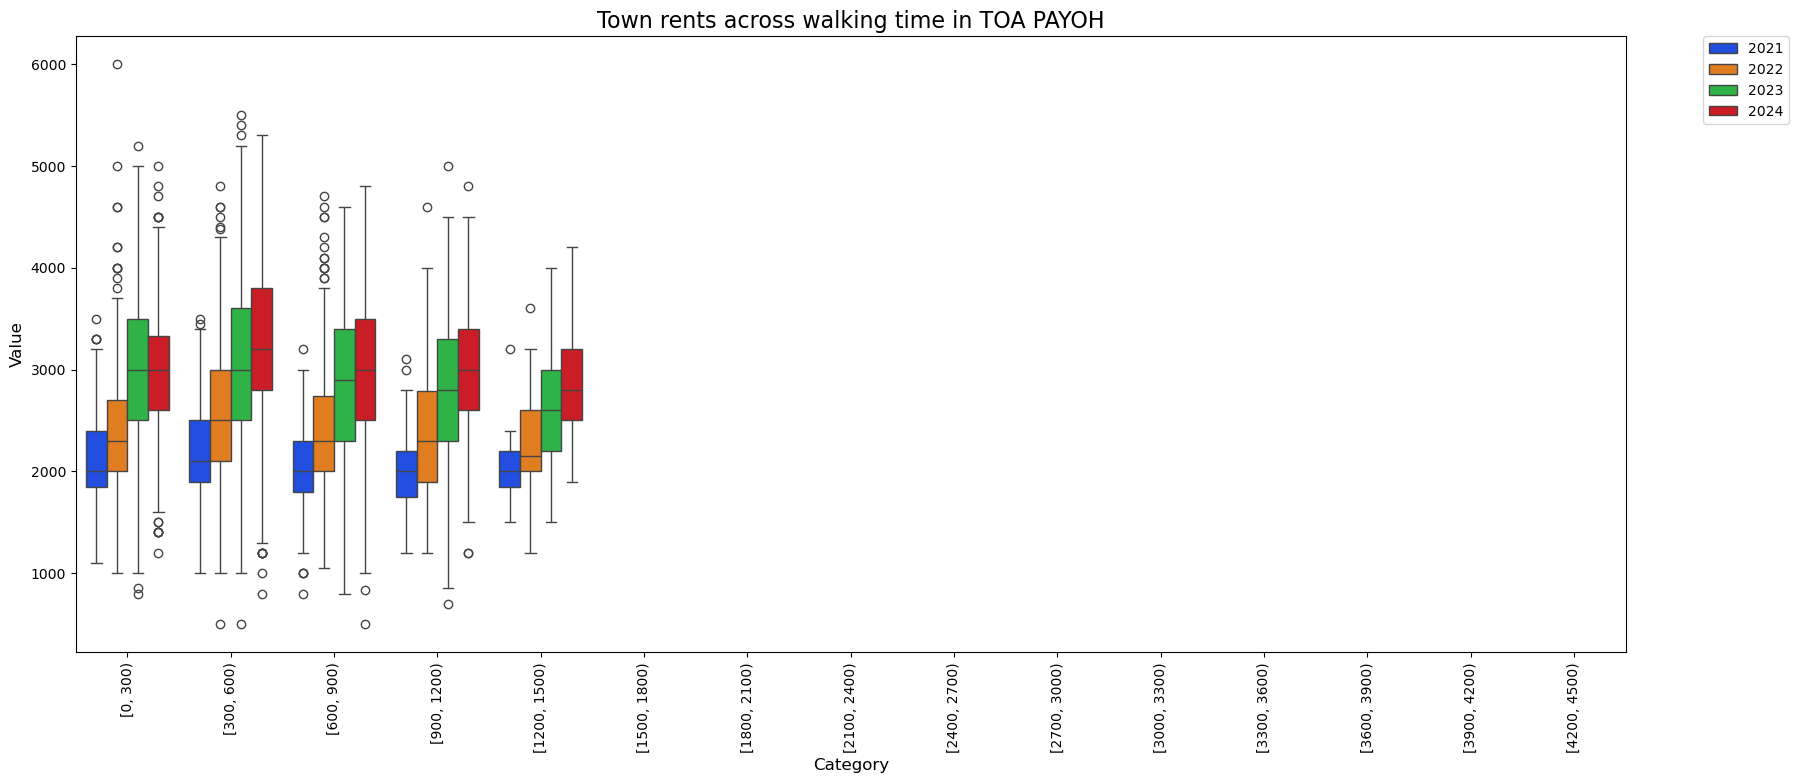

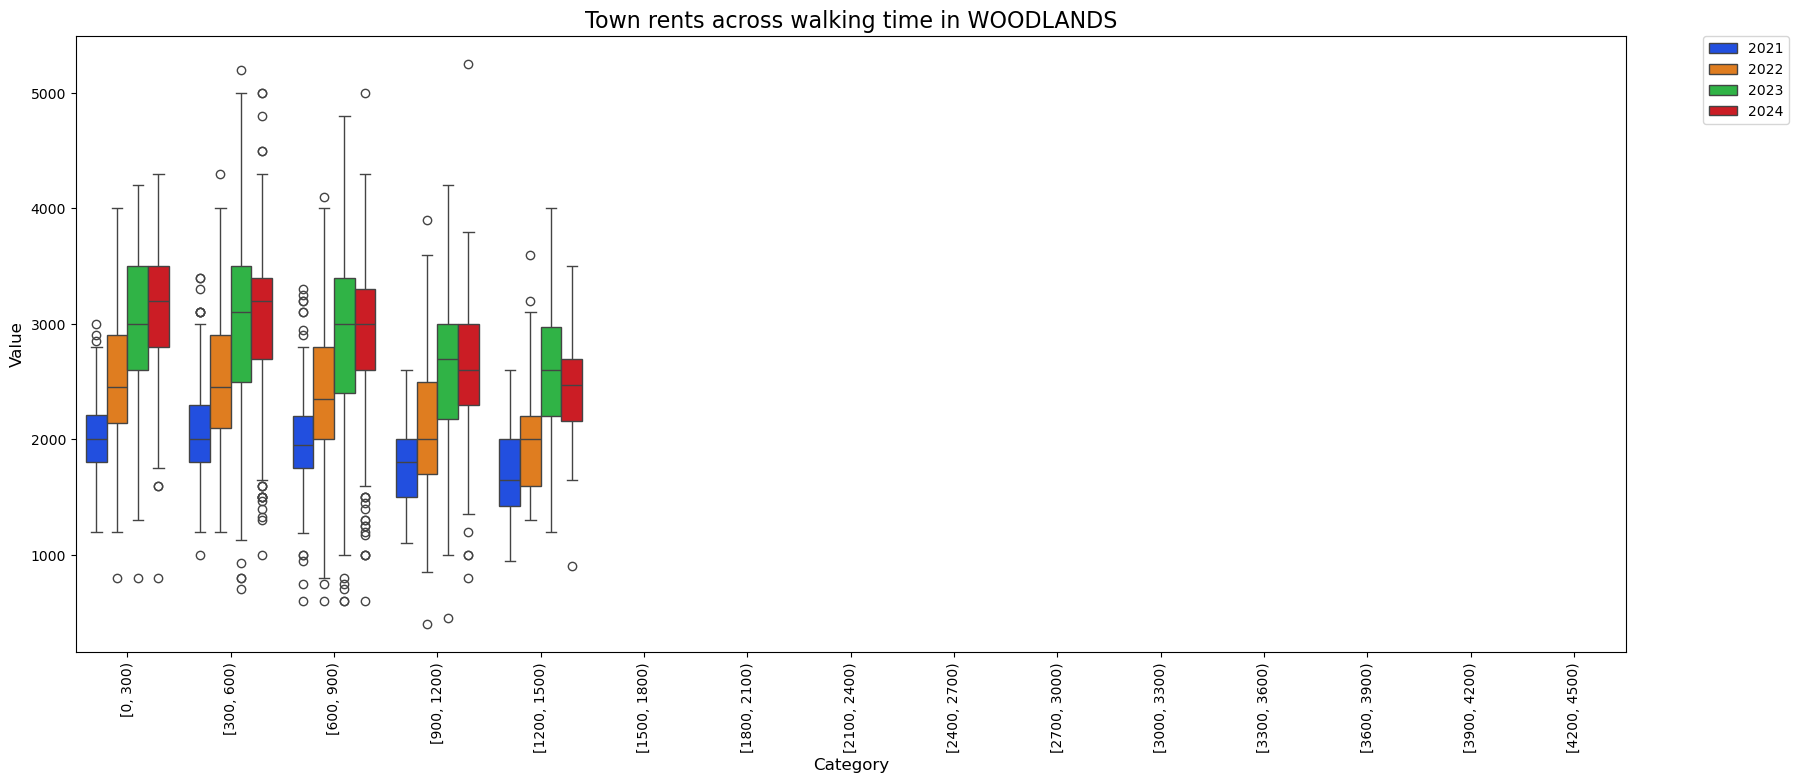

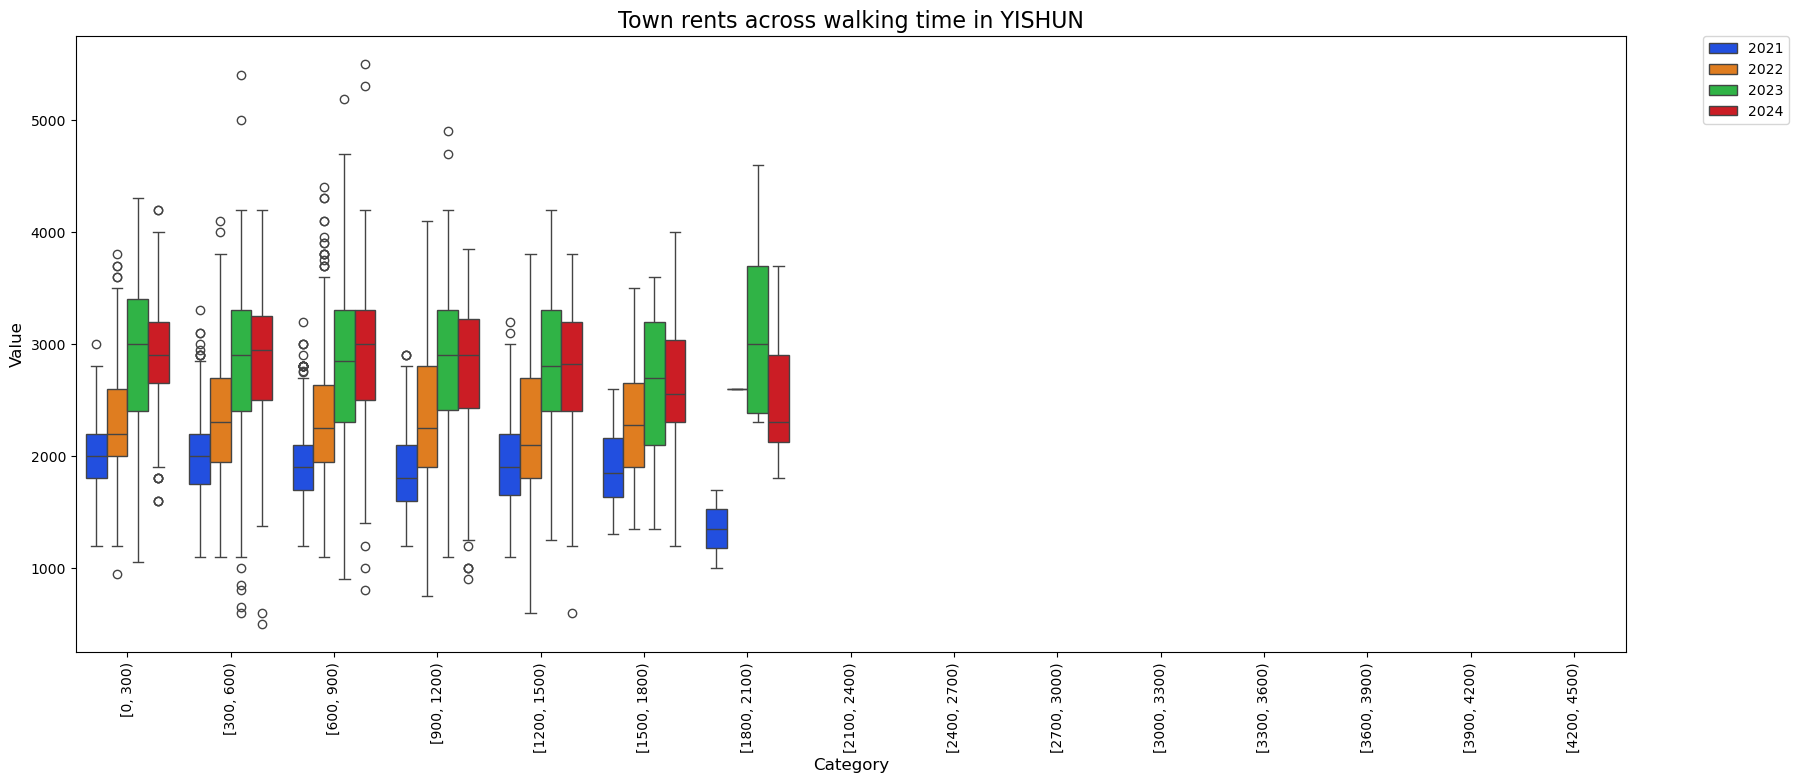

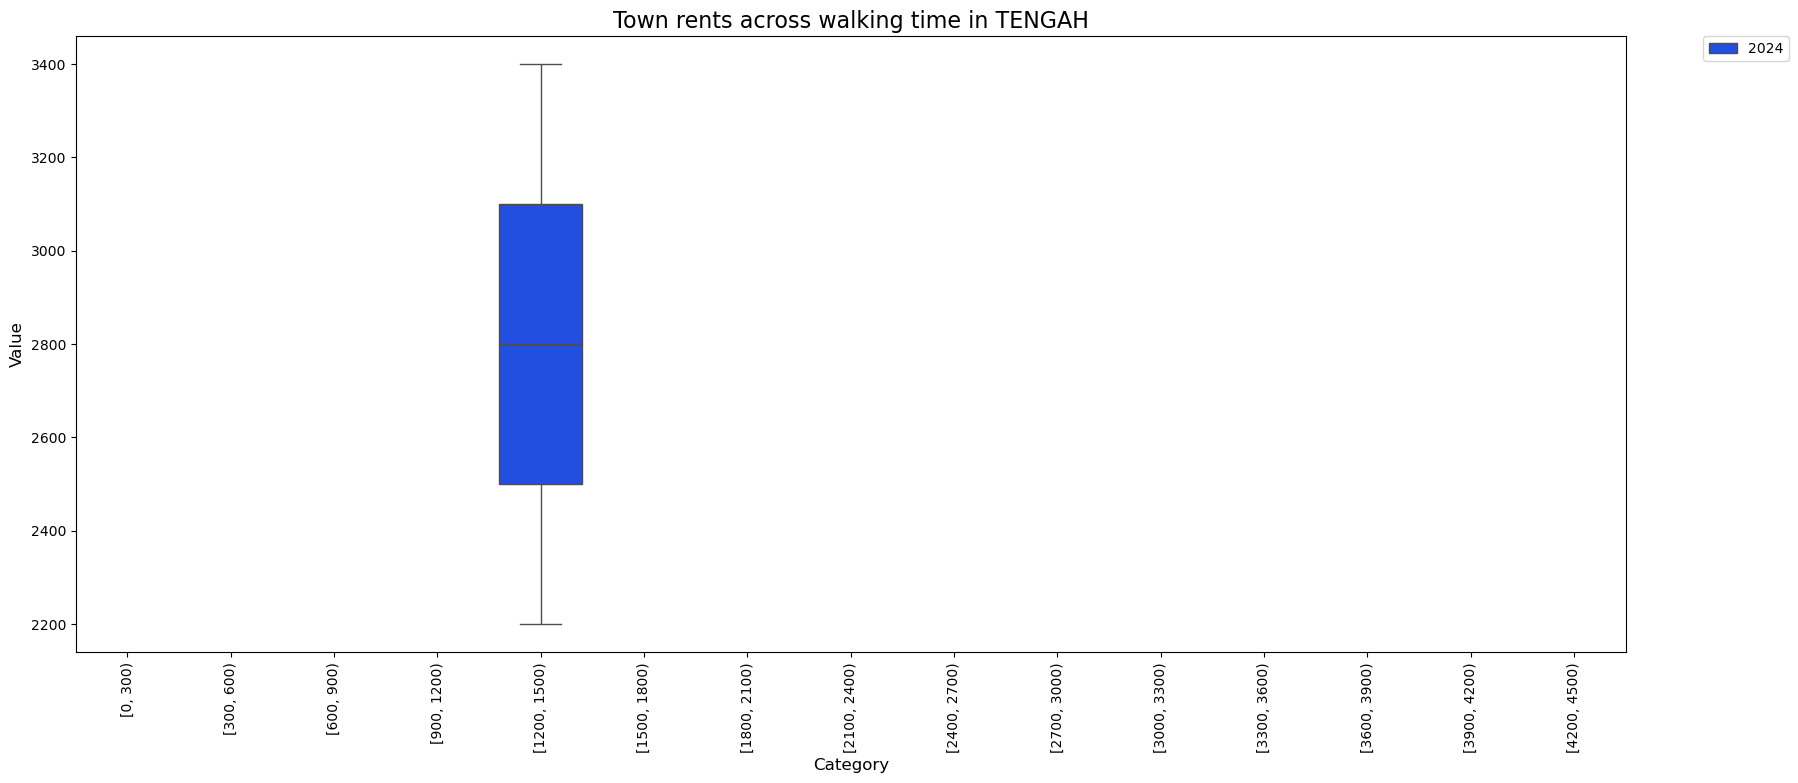

In [28]:
for town in main_rental_data_df['town'].unique():
    df = main_rental_data_df[main_rental_data_df['town'] == town]
    town = town.replace('/', '_')
    plotting(f'Town rents across walking time in {town}', 'boxplot', df, 'walking_time_interval', 'monthly_rent', 'year')